# <a id='toc1_'></a>[Function to compare distributions](#toc0_)

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def prepare_bi_data(m):
    data_dict = m.sampler.get_samples()
    # Initialize an empty DataFrame to collect parameters
    all_params = []

    # Loop through each array in the dictionary
    for key, array in data_dict.items():
        # Check the shape of the array
        if array.ndim > 1 and array.ndim < 3:
            # Create a DataFrame from the array and add a column for each parameter
            param_df = pd.DataFrame(array)
            # Rename columns to include the parameter name
            param_df.columns = [f"{key}_{j+1}" for j in range(array.shape[1])]
            all_params.append(param_df)
    
        elif array.ndim >= 3:# we have a matrix
            array_shape = array.shape
            row = array_shape[1]
            col = array_shape[2]
            for a in range(col):
                for b in range(row):
                    all_params.append(pd.DataFrame({key + '_' + str(a) +  '_' + str(b): array[:,a,b]}))
        else:
            # If it's a 1D array, create a single column DataFrame
            all_params.append(pd.DataFrame({key: array}))

    # Concatenate all parameter DataFrames along the rows
    df_bi = pd.concat(all_params, axis=1)
    return df_bi

def prepare_stan_data(df):
    columns_to_remove = ['lp__',	'accept_stat__',	'stepsize__',	'treedepth__',	'n_leapfrog__',	'divergent__',	'energy__']
    d = df.drop(columns=columns_to_remove)
    return d

def combine_data(df_bi, d):
    #df_bi = pd.DataFrame(samples)
    params = df_bi.columns.values
    d.columns = df_bi.columns

    df_bi['method'] = 'BI'
    d['method'] = 'STAN'
    d_comb = pd.concat([d, df_bi], ignore_index=True)
    return d_comb

def plot_comparaison(m, df):

    d = prepare_stan_data(df)
    df_bi = prepare_bi_data(m)
    d_comb = combine_data(df_bi, d)

    # Calculate the number of rows needed
    params = df_bi.columns.values[:-1]
    num_params = len(params)
    num_cols = 3
    num_rows = (num_params + num_cols - 1) // num_cols  # Ceiling division

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 5), sharey=True)
    if num_rows * num_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    a = 0

    for i in d_comb.columns:
        if i in params:
            if a == 0:
                axes[a].set_ylabel('Density')
                sns.kdeplot(data=d_comb, x=i, hue='method', ax=axes[a], fill=True, color='blue', alpha=0.5, legend=True)
                axes[a].spines['right'].set_visible(False)
                a += 1
            elif a == num_params:
                print('found')
                sns.kdeplot(data=d_comb, x=i, hue='method', ax=axes[a], fill=True, color='blue', alpha=0.5, legend=True)
                a += 1
            elif a < num_params:
                sns.kdeplot(data=d_comb, x=i, hue='method', ax=axes[a], fill=True, color='blue', alpha=0.5, legend=False)
                a += 1


    plt.subplots_adjust(wspace=0.0, left=0.1, right=0.9)
    axes[1].set_yticks([])

    # Remove extra subplots if there are any
    for a in range(len(params), len(axes)):
        fig.delaxes(axes[a])

    plt.subplots_adjust(wspace=0.0, left=0.1, right=0.9)
    axes[1].set_yticks([])
    plt.show()
    return plt


# <a id='toc2_'></a>[Rethinking](#toc0_)

## <a id='toc2_1_'></a>[1. Continuous variable: Model (model 4.3)](#toc0_)

### <a id='toc2_1_1_'></a>[BI](#toc0_)

In [70]:
import os
import sys
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)

from main import *
import time as tm
# setup platform------------------------------------------------
m = bi(platform='cpu')

# import data ------------------------------------------------
m.data('../resources/data/Howell1.csv', sep=';') 
m.df = m.df[m.df.age > 18]
m.scale(['weight'])
#m.data_to_model(['weight', 'height'])

 # define model ------------------------------------------------
def model(weight, height):    
    a = dist.normal( 178, 20, name = 'a',shape= [1])
    b = dist.lognormal(  0, 1, name = 'b',shape= [1])   
    s = dist.uniform( 0, 50, name = 's',shape = [1])
    lk("y", Normal(a + b * weight , s), obs=height)

# Run sampler ------------------------------------------------
m.run(model, num_samples=500) 
m.summary()

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1161.56it/s, 3 steps of size 8.14e-01. acc. prob=0.89]


mean    sd  hdi_5.5%  hdi_94.5%
a[0]  154.64  0.26    154.25     155.07
b[0]    5.81  0.28      5.35       6.23
s[0]    5.17  0.19      4.86       5.45

### <a id='toc2_1_2_'></a>[STAN](#toc0_)

In [71]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
nest_asyncio.apply()
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass
stan_code = """
data{
  vector[346] height;
  vector[346] weight;
}
parameters{
  real a;
  real<lower=0> b;
  real<lower=0,upper=50> s;
}
model{
  vector[346] mu;
  s ~ uniform( 0 , 50 );
  b ~ lognormal( 0 , 1 );
  a ~ normal( 178 , 20 );
  for ( i in 1:346 ) {
    mu[i] = a + b* weight[i] ;
  }
  height ~ normal( mu , s );  
  
}
"""
data = {
  'height': m.df.height.values,
  'weight': m.df.weight.values,
}
start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...

INFO:aiohttp.access:127.0.0.1 [14/Jan/2025:14:03:18 +0100] "POST /v1/models/uli54jc5/params HTTP/1.1" 200 363 "-" "Python/3.10 aiohttp/3.9.3"
INFO:httpstan:Found Stan model in cache (`models/uli54jc5`).
INFO:aiohttp.access:127.0.0.1 [14/Jan/2025:14:03:18 +0100] "POST /v1/models HTTP/1.1" 201 1607 "-" "Python/3.10 aiohttp/3.9.3"



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_25n9oqj1/model_uli54jc5.stan', line 15, column 20: Argument
    20 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_25n9oqj1/model_uli54jc5.stan', line 15, column 14: Argument
    178 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_25n9oqj1/model_uli54jc5.stan', line 13, column 19: Argument
    50 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    its declaration. These hard constraints are not recommended, for two
    reasons: (a) Except when there are logical or physical constraints, it is
    very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a

Pystan took: 0.2183 seconds


### <a id='toc2_1_3_'></a>[Output comparison](#toc0_)

In [72]:
plot_comparaison(m, df)

<module 'matplotlib.pyplot' from '/home/sosa/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

### <a id='toc2_1_4_'></a>[Parameter recovery](#toc0_)


jax.local_device_count 32


/tmp/ipykernel_660829/1079003774.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(data)], axis = 0, ignore_index=True)


jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_de

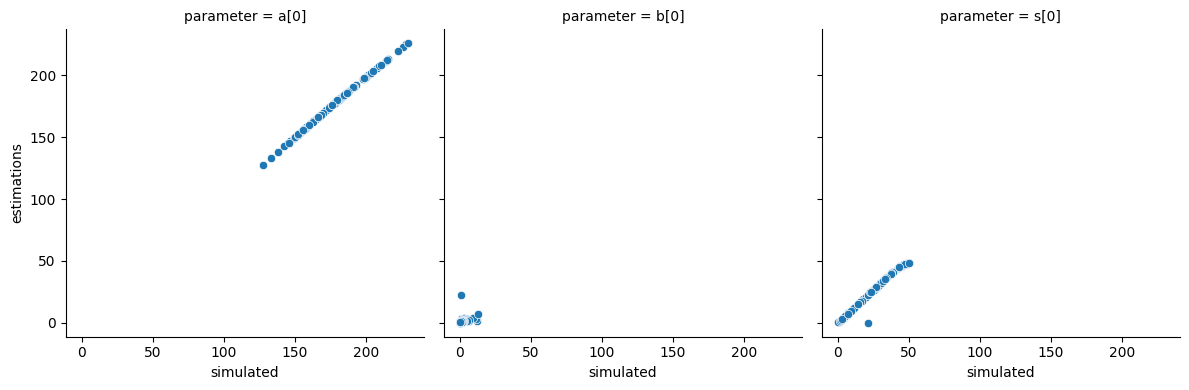

In [73]:
from main import*

def model(height, weight):    
    a = dist.normal( 178, 20, name = 'a',shape= [1])
    b = dist.lognormal( 0, 1, name = 'b',shape= [1])   
    s = dist.uniform( 0, 50, name = 's',shape = [1])
    lk("y", Normal(a + b * weight , s), obs=height)

def simulate_height(weight, a, b, s):    
    weight = (weight - weight.mean())/weight.std()
    height = dist.normal( a + b * weight , s, sample = True)
    return weight,height

def estimate(weight, a, b, s):
    weight, height = simulate_height(weight,a, b, s)
    m = bi(platform='cpu')
    m.df = pd.DataFrame({"weight": weight, "height": height})
    m.scale(['weight'])
    m.data_to_model(['weight', 'height'])
    m.run(model, num_samples=500, progress_bar=False) 
    s = m.summary()
    return s.iloc[:,0]

def plot_recovery(res):
    g = sns.FacetGrid(res, col="parameter", col_wrap=3, height=4)
    res['simulated'] = res['simulated'].astype(float)
    res['estimations'] = res['estimations'].astype(float)
    g.map(sns.scatterplot, "simulated", "estimations")

def param_recovery(weight, a, b, s, N, nsim):
    df = pd.DataFrame(columns=['sim', 'parameter', 'simulated', 'estimations'])

    for i in range(nsim):
        estimations = estimate(weight[i,:], a[i,:], b[i,:], s[i,:])
        data = {'sim': [i,i,i], 'parameter': estimations.index.values, 'simulated' : [a[i,:][0], b[i,:][0], s[i,:][0]], 'estimations': estimations.values}
        df = pd.concat([df, pd.DataFrame(data)], axis = 0, ignore_index=True)

    plot_recovery(df)    

    return df

N = 100
nsim = 100
a = bi.dist.normal(178, 20, shape=(nsim, 1), sample=True)
b = bi.dist.lognormal(0, 1, shape=(nsim, 1,), sample=True)
s = bi.dist.uniform(0, 50, shape=(nsim, 1), sample=True)
weight = dist.normal( 80, 30, sample = True, shape = (nsim, N))
res = param_recovery(weight, a, b, s, N, nsim = nsim)

## <a id='toc2_2_'></a>[2. Categorical variable: Model (model 5.9)](#toc0_)

### <a id='toc2_2_1_'></a>[BI](#toc0_)

In [3]:
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')
# import data ------------------------------------------------
m.data('../resources/data/milk.csv', sep=';') 
m.index(["clade"])
m.scale(['kcal_per_g'])
m.scale

def model(kcal_per_g, index_clade):
    a = bi.dist.normal(0, 0.5, shape=(4,), name = 'a')
    s = bi.dist.exponential( 1, shape = (1,), name = 's')    
    m = a[index_clade]
    lk("y", Normal(m, s), obs=kcal_per_g)

m.data_to_model(['kcal_per_g', "index_clade"])
m.run(model) 
m.sampler.print_summary(0.89)


jax.local_device_count 16


sample: 100%|██████████| 1000/1000 [00:02<00:00, 467.01it/s, 7 steps of size 7.07e-01. acc. prob=0.90]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     -0.46      0.24     -0.45     -0.88     -0.13    592.15      1.00
      a[1]      0.33      0.23      0.34     -0.04      0.67    434.59      1.00
      a[2]      0.66      0.26      0.67      0.25      1.08    595.34      1.00
      a[3]     -0.56      0.31     -0.56     -1.02     -0.04    430.78      1.00
      s[0]      0.79      0.11      0.78      0.61      0.97    412.52      1.00

Number of divergences: 0


### <a id='toc2_2_2_'></a>[STAN](#toc0_)

In [258]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()
stan_code = """
data{
    vector[29] K;
    array[29] int clade_id;
}
parameters{
    vector[4] a;
    real<lower=0> s;
}
model{
    vector[29] mu;
    s ~ exponential( 1 );
    a ~ normal( 0 , 0.5 );
    for ( i in 1:29 ) {
        mu[i] = a[clade_id[i]];
    }
    K ~ normal( mu , s );
    
}
"""
data = {
  'clade_id': m.df.index_clade.values+1,
  'K': m.df.kcal_per_g.values,
}
start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: 16.1s, done.Sampling:   0%
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 0.000249 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.49 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_1r2y_c3_/model_kvvrot3p.stan', line 17, column 4 to column 25)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


Pystan took: 16.2745 seconds


### <a id='toc2_2_3_'></a>[Output comparaison](#toc0_)

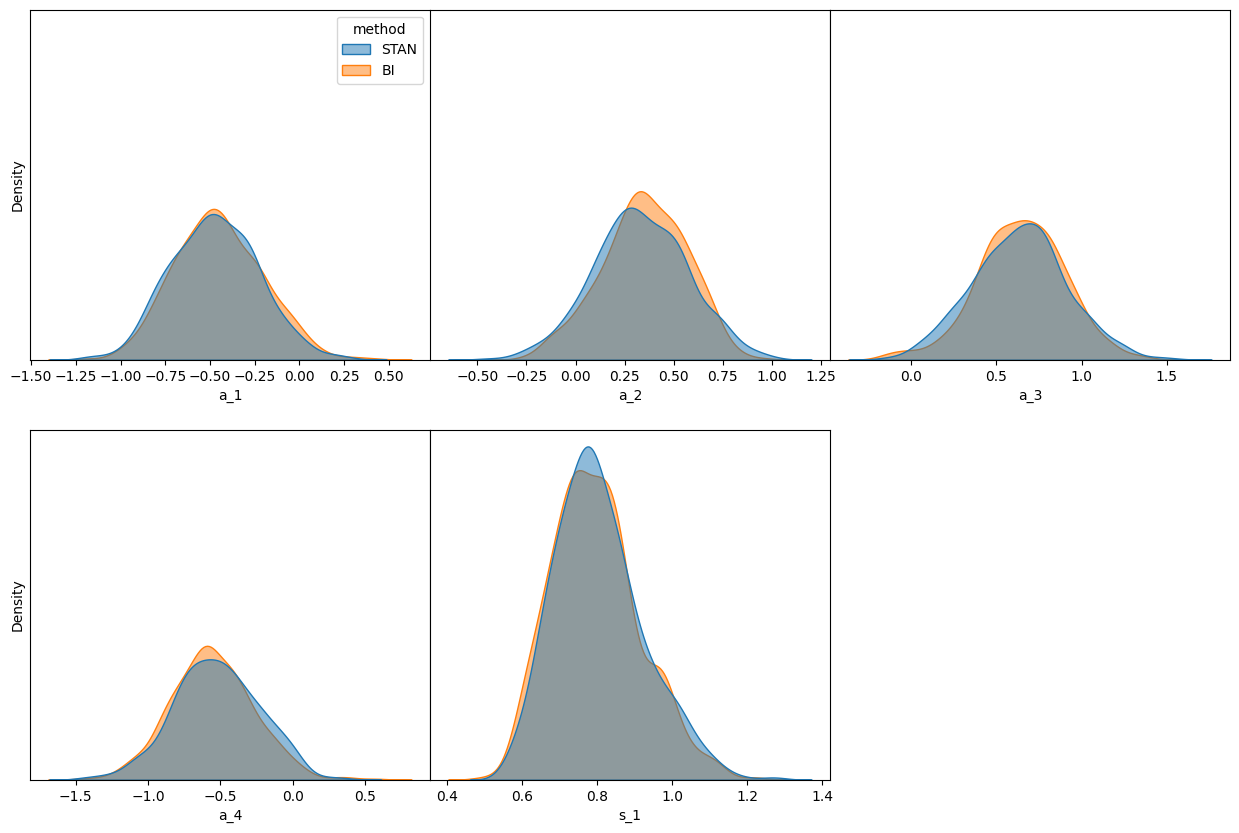

<module 'matplotlib.pyplot' from '/home/sosa/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [259]:
plot_comparaison(m, df)

### <a id='toc2_2_4_'></a>[Parameter recovery](#toc0_)

In [ ]:
from main import*
m = bi(platform='cpu')

def model(kcal_per_g, index_clade):
    a = bi.dist.normal(0, 0.5, shape=(4,), name = 'a')
    s = bi.dist.exponential( 1, shape = (1,), name = 's')    
    m = a[index_clade]
    lk("y", Normal(m, s), obs=kcal_per_g)

def simulate_data(a, sigma, N):
    index_clade = bi.dist.categorical(probs=jnp.array([0.25,0.25,.25,.25]), shape = (N,), sample=True).astype(int) # Generate clade index
    m = a[index_clade] # Generate mean of each clade
    cal = dist.normal( m, sigma, sample = True) # Generate calories based on mean and std
    return cal, index_clade
    
def estimate(alpha, sigma, N):
    cal, index_clade = simulate_data(alpha, sigma, N) # Simulate data
    # Run model
    m = bi(platform='cpu')
    m.df = pd.DataFrame({"kcal_per_g": cal, "index_clade": index_clade})
    #m.scale(['kcal_per_g'])
    m.data_to_model(['kcal_per_g', 'index_clade'])
    m.run(model, num_samples=500, progress_bar=False) 
    s = m.summary()
    return s.iloc[:,0]

def plot_recovery(res):
    g = sns.FacetGrid(res, col="parameter", col_wrap=3, height=4)
    res['simulated'] = res['simulated'].astype(float)
    res['estimations'] = res['estimations'].astype(float)
    g.map(sns.scatterplot, "simulated", "estimations")

def param_recovery(a, sigma, N, nsim):
    df = pd.DataFrame(columns=['sim', 'parameter', 'simulated', 'estimations'])

    for i in range(nsim):
        estimations = estimate(a[i], sigma[i], N)
        data = {'sim': np.repeat(i, len(estimations.index.values)), 
                'parameter': estimations.index.values, 
                'simulated' : jnp.concatenate([jnp.array(a[i]), jnp.array([sigma[i][0]])]), 
                'estimations': estimations.values}
        df = pd.concat([df, pd.DataFrame(data)], axis = 0, ignore_index=True)

    plot_recovery(df)    

    return df

N = 30
Ngrp = 4
nsim = 100
a = bi.dist.normal(0, 1, shape=(nsim, Ngrp,), sample=True, seed = 0)
sigma = bi.dist.halfcauchy(1, shape=(nsim, 1,), sample=True, seed = 10)

result = param_recovery(a,sigma, N = N, nsim = nsim)

In [19]:
N = 30
Ngrp = 4
nsim = 100
a = bi.dist.normal(0, 1, shape=(nsim, ), sample=True, seed = 0)
b = bi.dist.normal(0, 1, shape=(nsim, ), sample=True, seed = 0)
sigma = bi.dist.halfcauchy(1, shape=(nsim,), sample=True, seed = 10)
print(a.shape)
print(b.shape)
print(s.shape)

(100,)
(100,)
(1,)


In [20]:
a * b

Array([6.42329434e+00, 9.72695511e-01, 8.38494612e-02, 3.47295816e-01,
       9.66300731e-02, 2.87474115e+00, 6.31260670e-01, 2.93450812e+00,
       1.52793067e+00, 1.92856343e-01, 6.38948816e-04, 4.54714896e-02,
       2.04300285e+00, 4.38258476e-02, 3.59264432e+00, 2.27419464e-02,
       2.59401343e-02, 1.17698828e+00, 4.98917956e-01, 4.17440126e-04,
       8.59567103e-02, 4.45962263e-01, 7.93745564e-01, 2.89297724e-01,
       4.55085823e-02, 5.20125916e+00, 2.43339716e-01, 1.90470679e-01,
       5.87857103e-01, 7.44306466e-01, 2.59645646e-04, 2.95077423e-03,
       4.10289376e+00, 1.57766209e+00, 6.27864009e+00, 1.29356757e-01,
       5.65790733e-04, 5.26554093e-02, 8.46669356e-01, 4.76944673e-02,
       6.04335282e-01, 1.44293355e+00, 2.71572441e+00, 1.55120273e+00,
       1.42953552e+00, 7.88712764e-03, 1.57688271e+00, 9.43614508e-01,
       2.40402182e+00, 1.71383222e-01, 4.06594078e+00, 2.47588052e-03,
       1.80200723e-01, 1.00552550e+00, 3.63926525e+00, 2.76753633e-01,
      

## <a id='toc2_3_'></a>[3. Continuous interactions terms (model 8.3)](#toc0_)

### <a id='toc2_3_1_'></a>[BI](#toc0_)

In [5]:
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')
# import data ------------------------------------------------
m.data('../resources/data/tulips.csv', sep=';') 
m.scale(['blooms', 'water', 'shade'])

 # define model ------------------------------------------------
def model(blooms,shade, water):
    sigma = dist.exponential(1, name = 'sigma')
    bws = dist.normal(0, 0.25, name = 'bws')
    bs = dist.normal(0, 0.25, name = 'bs')
    bw = dist.normal(0, 0.25, name = 'bw')
    a = dist.normal(0.5, 0.25, name = 'a')
    mu = a + bw*water + bs*shade + bws*water*shade
    lk("y", Normal(mu, sigma), obs=blooms)

# Run sampler ------------------------------------------------ 
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)


jax.local_device_count 16


g:\OneDrive\Travail\Max Planck\Projects\BI\bi\data\manip.py:73: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.20185043 -1.20185043 -1.20185043  0.          0.          0.
  1.20185043  1.20185043  1.20185043 -1.20185043 -1.20185043 -1.20185043
  0.          0.          0.          1.20185043  1.20185043  1.20185043
 -1.20185043 -1.20185043 -1.20185043  0.          0.          0.
  1.20185043  1.20185043  1.20185043]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.df.loc[:, cols[a]] = (self.df.loc[:, cols[a]] - self.df.loc[:, cols[a]].mean()) / self.df.loc[:, cols[a]].std()
g:\OneDrive\Travail\Max Planck\Projects\BI\bi\data\manip.py:73: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.20185043  0.          1.20185043 -1.20185043  0.          1.20185043
 -1.20185043  0.          1.20185043 -1.20


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.09      0.10      0.08     -0.08      0.25    571.75      1.01
        bs     -0.31      0.10     -0.30     -0.47     -0.15    691.05      1.00
        bw      0.57      0.10      0.57      0.38      0.70    626.92      1.00
       bws     -0.32      0.11     -0.32     -0.52     -0.16    453.70      1.00
     sigma      0.58      0.10      0.56      0.42      0.70    294.75      1.00

Number of divergences: 0


### <a id='toc2_3_2_'></a>[STAN](#toc0_)

In [102]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()

stan_code = """
data{
    vector[27] blooms_std;
    array[27] int shade_cent;
    array[27] int water_cent;
}
parameters{
    real a;
    real bs;
    real bw;    
    real bws;
    real<lower=0> sigma;
}
model{
    vector[27] mu;
    sigma ~ exponential( 1 );
    bws ~ normal( 0 , 0.25 );
    bs ~ normal( 0 , 0.25 );
    bw ~ normal( 0 , 0.25 );
    a ~ normal( 0.5 , 0.25 );
    for ( i in 1:27 ) {
        mu[i] = a + bw * water_cent[i] + bs * shade_cent[i] + bws * water_cent[i] * shade_cent[i];
    }

    
    blooms_std ~ normal( mu , sigma );
}
"""

data = {
    'blooms_std' : m.df["blooms"].values,
    "water_cent": m.df["water"].values.astype(int),
    "shade_cent": m.df["shade"].values.astype(int),
}
start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: 12.3s, done.Sampling:   0%
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_e8csemox/model_nwjaezfb.stan', line 26, column 4 to column 38)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


Pystan took: 12.4235 seconds


### <a id='toc2_3_3_'></a>[Output comparison](#toc0_)

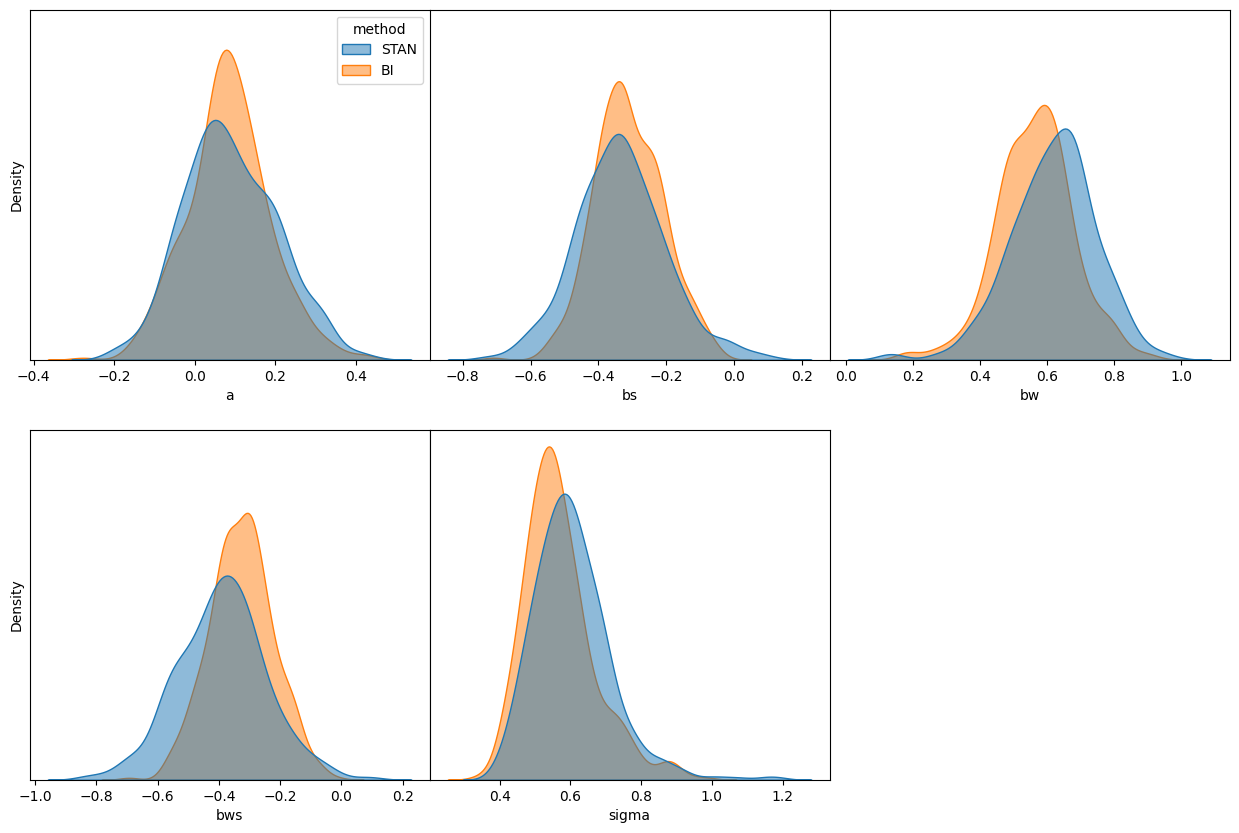

<module 'matplotlib.pyplot' from '/home/sosa/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [103]:
plot_comparaison(m, df)

### <a id='toc2_3_4_'></a>[Parameter recovery](#toc0_)

In [92]:
from main import*
m = bi(platform='cpu')

def model(blooms,shade, water):
    a = dist.normal(0, 1, name = 'a')    
    bws = dist.normal(0,1, name = 'bws')
    bs = dist.normal(0, 1, name = 'bs')
    bw = dist.normal(0, 1, name = 'bw')
    sigma = dist.exponential(1, name = 'sigma')
    
    mu = a + bw*water + bs*shade + bws*water*shade
    lk("y", Normal(mu, sigma), obs=blooms)
    
def simulate_bloom(water, shade, sigma,bws, bs, bw, a ):
    mu = a + bw*water + bs*shade + bws*water*shade
    return  bi.dist.normal(mu, sigma, sample=True) # bloom
    
def estimate(water, shade, sigma,bws, bs, bw, a ):
    blooms = simulate_bloom(water, shade, sigma,bws, bs, bw, a ) # Simulate data
    # Run model
    m = bi(platform='cpu')
    m.df = pd.DataFrame({"water": water, "shade": shade, "blooms": blooms})
    #m.scale(['blooms', 'shade', 'blooms'])
    m.run(model, num_samples=500, progress_bar=False) 
    s = m.summary()
    return s.iloc[:,0]

def plot_recovery(res):
    g = sns.FacetGrid(res, col="parameter", col_wrap=3, height=4)
    res['simulated'] = res['simulated'].astype(float)
    res['estimations'] = res['estimations'].astype(float)
    g.map(sns.scatterplot, "simulated", "estimations")

def param_recovery(water, shade, sigma,bws, bs, bw, a, nsim):
    df = pd.DataFrame(columns=['sim', 'parameter', 'simulated', 'estimations'])

    for i in range(nsim):
        estimations = estimate(water, shade, sigma[i], bws[i], bs[i], bw[i], a[i] )
        data = {'sim': np.repeat(i, len(estimations.index.values)), 
                'parameter': estimations.index.values, 
                'simulated' : jnp.concatenate([sigma[i], bws[i], bs[i], bw[i], a[i]]), 
                'estimations': estimations.values}
        df = pd.concat([df, pd.DataFrame(data)], axis = 0, ignore_index=True)

    plot_recovery(df)    

    return df

nsim = 5
# Shade and water are all possible conbinations of shade (1 to 3) and water (1 to 3)
m.data('../resources/data/tulips.csv', sep=';') 
shade = m.df.shade.values
water = m.df.water.values
sigma = dist.exponential(1, name = 'sigma', shape = (nsim, 1,), sample = True)
bws = dist.normal(0, 1, name = 'bws', shape = (nsim, 1,), sample = True, seed = 1)
bs = dist.normal(0,1, name = 'bs', shape = (nsim, 1,), sample = True, seed = 2)
bw = dist.normal(0, 1, name = 'bw', shape = (nsim, 1,), sample = True, seed = 3)
a = dist.normal(0, 1, name = 'a', shape = (nsim, 1,), sample = True, seed = 4)

result = param_recovery(water, shade, sigma,bws, bs, bw, a, nsim = nsim)

jax.local_device_count 32
jax.local_device_count 32


/tmp/ipykernel_660829/1256976596.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(data)], axis = 0, ignore_index=True)


jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32


## <a id='toc2_4_'></a>[4. Binomial (model 11.1)](#toc0_)

### <a id='toc2_4_1_'></a>[BI](#toc0_)

In [1]:
import pandas as pd
d = pd.read_csv('resources/data/chimpanzees.csv', sep = ';')
d["treatment"] = 1 + d.prosoc_left + 2 * d.condition
d["side"] = d.prosoc_left  # right 0, left 1
d["cond"] = d.condition  # no partner 0, partner 1

In [3]:
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')
# import data ------------------------------------------------
m.data('resources/data/chimpanzees.csv', sep=';') 
#m.df['treatment'] =  1 + m.df.prosoc_left + 2 * m.df.condition
#m.df["side"] = m.df.prosoc_left  # right 0, left 1
#m.df["cond"] = m.df.condition  # no partner 0, partner 1
#m.data_to_model(['pulled_left', ])

def model(pulled_left):
    a = dist.normal( 0, 10)
    lk("y", Binomial(logits=a), obs=pulled_left)

# Run sampler ------------------------------------------------
m.run(model, init_strategy = numpyro.infer.initialization.init_to_mean()) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)


jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1495.29it/s, 1 steps of size 9.81e-01. acc. prob=0.94]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         x      0.32      0.09      0.32      0.17      0.45    160.57      1.00

Number of divergences: 0


### <a id='toc2_4_2_'></a>[STAN](#toc0_)

In [106]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()

stan_code = """
data{
    array[504] int pulled_left;
}
parameters{
    real a;
}
model{
    real p;
    a ~ normal( 0 , 10 );
    p = a;
    p = inv_logit(p);
    pulled_left ~ binomial( 1 , p );    
}
"""

data = {
    'pulled_left' : m.df["pulled_left"].values.astype(int)
}
start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: 10.5s, done.Sampling:   0%
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!


Pystan took: 10.5954 seconds


### <a id='toc2_4_3_'></a>[Output comparison](#toc0_)

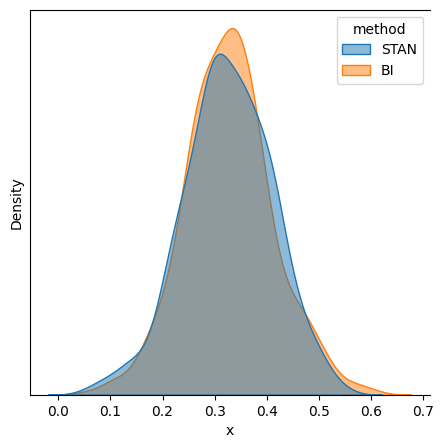

<module 'matplotlib.pyplot' from '/home/sosa/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [107]:
plot_comparaison(m, df)

### <a id='toc2_4_4_'></a>[Parameter recovery](#toc0_)

jax.local_device_count 32


/tmp/ipykernel_4924/1710553979.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(data)], axis = 0, ignore_index=True)


jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_de

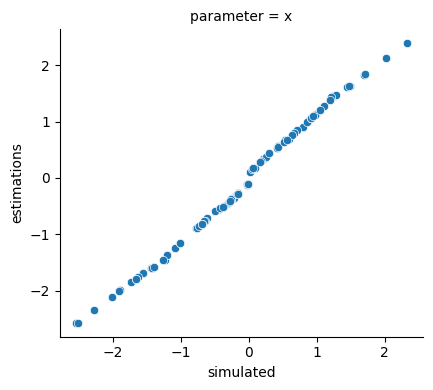

In [63]:
def model(pulled_left):
    a = dist.normal( 0, 10)
    lk("y", Binomial(logits=a), obs=pulled_left)

def sim_pulled_left(a):
    return dist.binomial(logits=a, sample=True, shape=(1000,))

def estimate(a):
    pulled_left = sim_pulled_left(a)[:,0] # Simulate data
    # Run model
    m = bi(platform='cpu')
    m.df = pd.DataFrame({"pulled_left": pulled_left})
    #m.scale(['blooms', 'shade', 'blooms'])
    m.run(model, num_samples=500, progress_bar=False) 
    s = m.summary()
    return s.iloc[:,0]

def plot_recovery(res):
    g = sns.FacetGrid(res, col="parameter", col_wrap=3, height=4)
    res['simulated'] = res['simulated'].astype(float)
    res['estimations'] = res['estimations'].astype(float)
    g.map(sns.scatterplot, "simulated", "estimations")

def param_recovery(a, nsim):
    df = pd.DataFrame(columns=['sim', 'parameter', 'simulated', 'estimations'])

    for i in range(nsim):
        estimations = estimate(a[i])
        data = {'sim': np.repeat(i, len(estimations.index.values)), 
                'parameter': estimations.index.values, 
                'simulated' : a[i], 
                'estimations': estimations.values}
        df = pd.concat([df, pd.DataFrame(data)], axis = 0, ignore_index=True)

    plot_recovery(df)    

    return df

nsim = 100
a = dist.normal( 0, 1, shape = (nsim, 1), sample=True)
result = param_recovery(a, nsim = nsim)

## <a id='toc2_5_'></a>[5. Binomial with indices (model 11.4)](#toc0_)

### <a id='toc2_5_1_'></a>[BI](#toc0_)

In [6]:
from main import *
m = bi(platform='cpu')
m.data('../resources/data/chimpanzees.csv', sep=';') 
m.df['treatment'] =  m.df.prosoc_left + 2 * m.df.condition
m.df['actor'] = m.df['actor'] - 1

m.data_to_model(['actor', 'treatment', 'pulled_left'])

def model(actor, treatment, pulled_left):
    a = dist.normal(0, 1.5, shape = (7,), name='a')
    b = dist.normal(0, 0.5, shape = (4,), name='b')
    p = a[actor] + b[treatment]
    lk("y", Binomial(1, logits=p), obs=pulled_left)

# Run sampler ------------------------------------------------
m.run(model) 
# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 16


sample: 100%|██████████| 1000/1000 [00:02<00:00, 413.73it/s, 3 steps of size 5.41e-01. acc. prob=0.88]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     -0.43      0.33     -0.42     -0.94      0.10    133.72      1.00
      a[1]      3.90      0.70      3.88      2.81      5.04    428.28      1.00
      a[2]     -0.74      0.34     -0.75     -1.32     -0.28    145.61      1.00
      a[3]     -0.76      0.35     -0.76     -1.34     -0.24    114.94      1.00
      a[4]     -0.45      0.34     -0.46     -1.00      0.11    159.08      1.00
      a[5]      0.49      0.33      0.49     -0.03      0.99    127.96      1.00
      a[6]      1.97      0.46      1.99      1.22      2.65    239.02      1.00
      b[0]     -0.03      0.29     -0.01     -0.45      0.45    113.17      1.00
      b[1]      0.48      0.30      0.48     -0.02      0.94     97.61      1.00
      b[2]     -0.40      0.31     -0.40     -0.90      0.07    125.00      1.00
      b[3]      0.36      0.30      0.36     -0.05      0.85    116.96      1.00

Number of divergences: 0


### <a id='toc2_5_2_'></a>[STAN](#toc0_)

In [121]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()

stan_code = """
data{
    array[504] int pulled_left;
    array[504] int treatment;
    array[504] int actor;
}
parameters{
    vector[7] a;
    vector[4] b;
}
model{
    vector[504] p;
    a ~ normal( 0 , 1.5 );
    b ~ normal( 0 , 0.5 );    
    for ( i in 1:504 ) {
        p[i] = a[actor[i]] + b[treatment[i]];
        p[i] = inv_logit(p[i]);
    }
    pulled_left ~ binomial( 1 , p );
}

"""

data = {
    'pulled_left' : m.df["pulled_left"].values.astype(int),
    'treatment' : m.df["treatment"].values.astype(int) + 1,
    'actor' : m.df["actor"].values.astype(int) +1 
}

start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: 12.9s, done.Sampling:   0%/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

Sampling:  10% (100/1000)
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 5.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
  Adjust your expectations accordingly!


Pystan took: 15.0782 seconds


### <a id='toc2_5_3_'></a>[Output comparison](#toc0_)

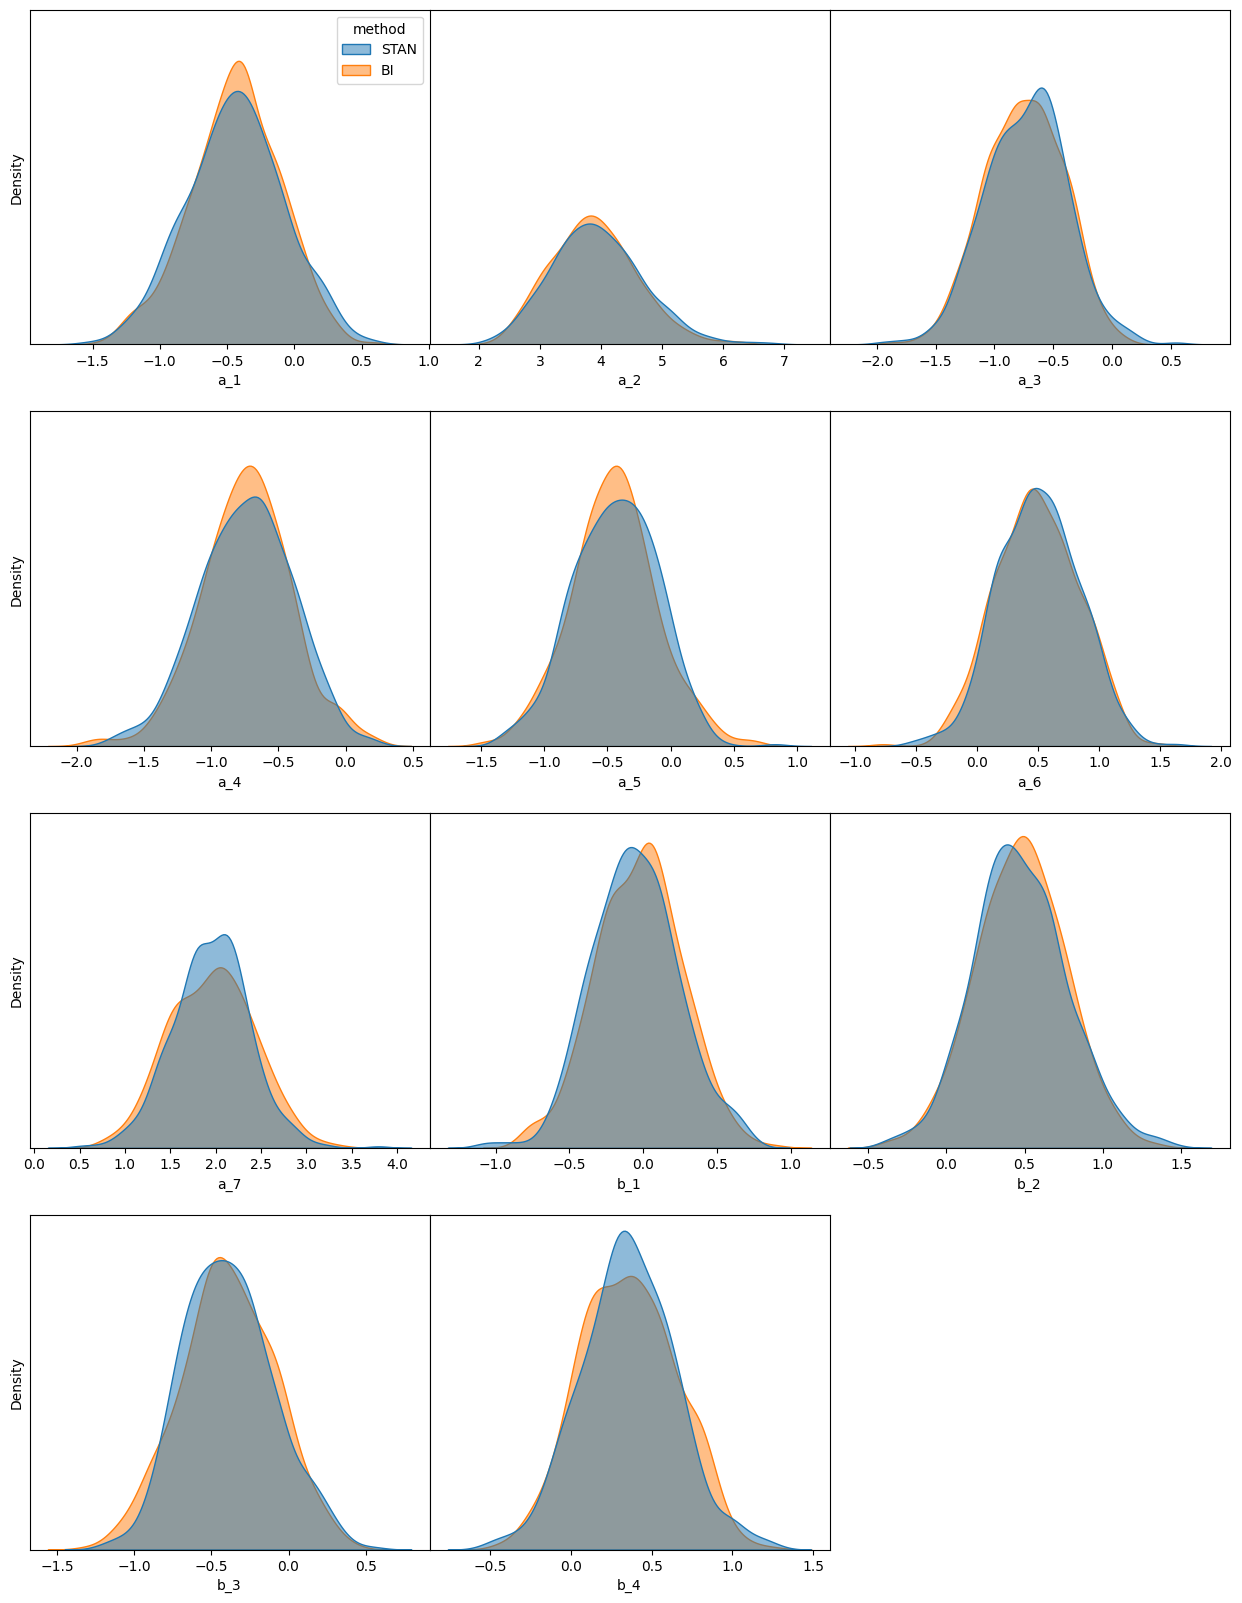

<module 'matplotlib.pyplot' from '/home/sosa/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [124]:
plot_comparaison(m, df)

### <a id='toc2_5_4_'></a>[Parameter recovery](#toc0_)

jax.local_device_count 32
jax.local_device_count 32


/tmp/ipykernel_4924/3564037553.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(data)], axis = 0, ignore_index=True)


jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_de

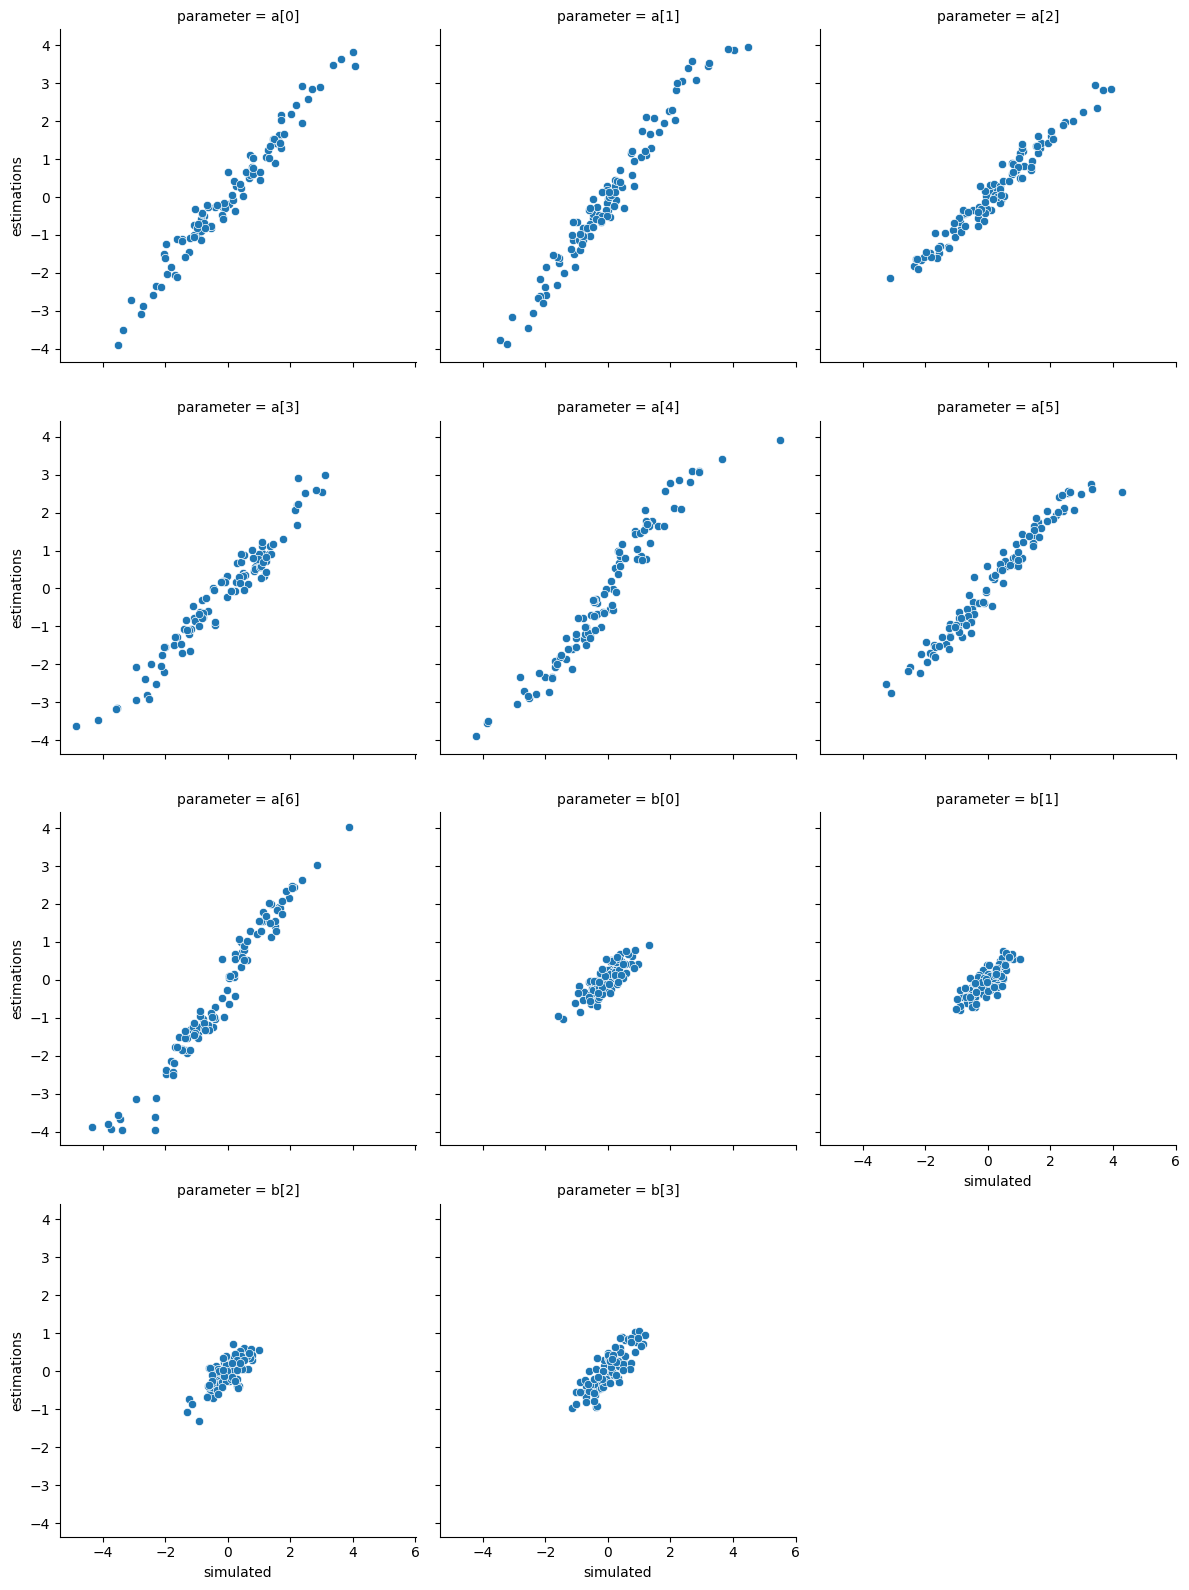

In [136]:
from main import *
m = bi(platform='cpu')
m.data('resources/data/chimpanzees.csv', sep=';') 
m.df['treatment'] =  m.df.prosoc_left + 2 * m.df.condition
m.df['actor'] = m.df['actor'] - 1

def model(actor, treatment, pulled_left):
    a = dist.normal(0, 1.5, shape = (7,), name='a')
    b = dist.normal(0, 0.5, shape = (4,), name='b')
    p = a[actor] + b[treatment]
    lk("y", Binomial(1, logits=p), obs=pulled_left)

def sim_pulled_left(actor, treatment, a, b):
    p = a[actor] + b[treatment]
    return dist.binomial(1, logits=p, sample=True)

def estimate(actor, treatment, a, b):
    pulled_left = sim_pulled_left(actor, treatment, a, b) # Simulate data
    # Run model
    m = bi(platform='cpu')
    m.df = pd.DataFrame({"pulled_left": pulled_left, "actor": actor, "treatment": treatment})
    m.run(model, num_samples=500, progress_bar=False) 
    s = m.summary()
    return s.iloc[:,0]

def plot_recovery(res):
    g = sns.FacetGrid(res, col="parameter", col_wrap=3, height=4)
    res['simulated'] = res['simulated'].astype(float)
    res['estimations'] = res['estimations'].astype(float)
    g.map(sns.scatterplot, "simulated", "estimations")

def param_recovery(actor, treatment, a, b, nsim):
    df = pd.DataFrame(columns=['sim', 'parameter', 'simulated', 'estimations'])

    for i in range(nsim):
        estimations = estimate(actor, treatment, a[i], b[i])
        data = {'sim': np.repeat(i, len(estimations.index.values)), 
                'parameter': estimations.index.values, 
                'simulated' : jnp.concatenate([a[i], b[i]]), 
                'estimations': estimations.values}
        df = pd.concat([df, pd.DataFrame(data)], axis = 0, ignore_index=True)

    plot_recovery(df)    

    return df

nsim = 100
actor = jnp.array(m.df['actor'])
treatment = jnp.array(m.df['treatment'])
a = dist.normal(0, 1.5, shape = (nsim, 7), name='a', sample=True)
b = dist.normal(0, 0.5, shape = (nsim, 4), name='b', sample=True)

result = param_recovery(actor, treatment, a, b, nsim)

## <a id='toc2_6_'></a>[6. Poisson (model 11.10)](#toc0_)

### <a id='toc2_6_1_'></a>[BI](#toc0_)

In [96]:
m.df

culture  population contact  total_tools  mean_TU  cid
0    Malekula   -0.389290     low           13      3.2    0
1     Tikopia   -0.384573     low           22      4.7    0
2  Santa Cruz   -0.359807     low           24      4.0    0
3         Yap   -0.345761    high           43      5.0    1
4    Lau Fiji   -0.314992    high           33      5.0    1
5   Trobriand   -0.307916    high           19      4.0    1
6       Chuuk   -0.293764    high           40      3.8    1
7       Manus   -0.248949     low           28      6.6    0
8       Tonga   -0.195878    high           55      5.4    1
9      Hawaii    2.840928     low           71      6.6    0

In [ ]:
dist.binomial(0.5, name='a', sample=True, seed = 1)

In [95]:
from main import *
# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------
m.data('../resources/data/Kline.csv', sep=';') 
m.scale(['population'])
m.df["cid"] = (m.df.contact == "high").astype(int)
#m.data_to_model(['total_tools', 'population', 'cid'])
def model(cid, population, total_tools):
    a = dist.normal(3, 0.5, shape= (2,), name='a')
    b = dist.normal(0, 0.2, shape=(2,), name='b')
    l = jnp.exp(a[cid] + b[cid]*population)
    lk("y", Poisson(l), obs=total_tools)

# Run sampler ------------------------------------------------
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1214.63it/s, 3 steps of size 5.79e-01. acc. prob=0.90]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      3.21      0.10      3.22      3.06      3.37    298.74      1.00
      a[1]      3.63      0.09      3.64      3.48      3.76    456.95      1.00
      b[0]      0.36      0.05      0.36      0.28      0.44    361.89      1.00
      b[1]      0.06      0.20      0.05     -0.24      0.35    271.41      1.00

Number of divergences: 0


### <a id='toc2_6_2_'></a>[STAN](#toc0_)

In [118]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()

stan_code = """ 
data{
    array[10] int T;
    vector[10] P;
    array[10] int cid;
}
parameters{
    vector[2] a;
    vector[2] b;
}
model{
    vector[10] lambda;
    b ~ normal( 0 , 0.2 );
    a ~ normal( 3 , 0.5 );
    for ( i in 1:10 ) {
       lambda[i] = a[cid[i]] + b[cid[i]] * P[i];
       lambda[i] = exp(lambda[i]);
    }
    T ~ poisson( lambda );
}

"""

data = {
    'T' : m.df["total_tools"].values.astype(int),
    'P' : m.df["population"].values.astype(float),
    'cid' : m.df["cid"].values.astype(int) +1
}

start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: 12.3s, done.Sampling:   0%
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!


Pystan took: 12.3988 seconds


### <a id='toc2_6_3_'></a>[Output comparison](#toc0_)

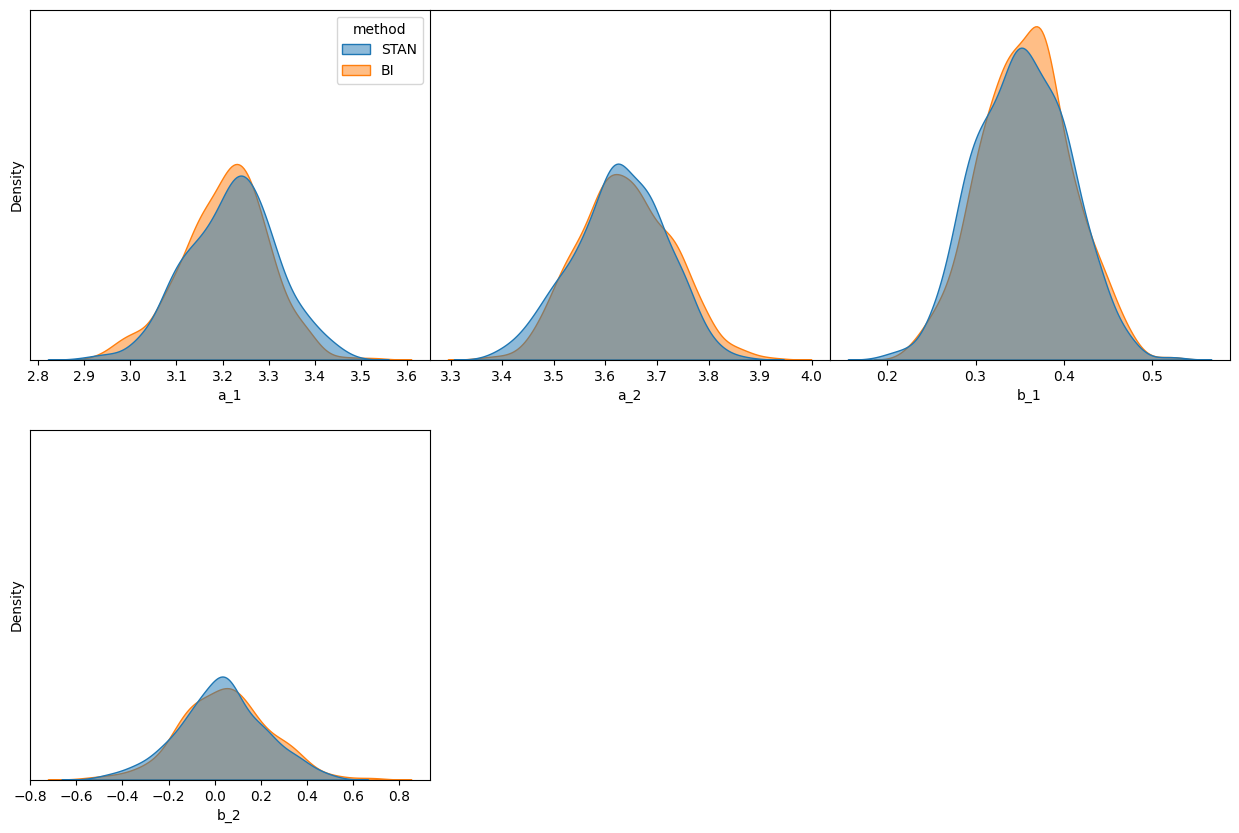

<module 'matplotlib.pyplot' from '/home/sosa/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [120]:
plot_comparaison(m, df)

### <a id='toc2_6_4_'></a>[Parameter recovery](#toc0_)

In [98]:
dist.normal(0, 0.2, shape=(nsim, 2,), name='b', sample=True, seed = 2)

Array([[-0.03832311, -0.20867175],
       [ 0.08570299, -0.03101705],
       [-0.13995612, -0.33672578],
       [ 0.11254353, -0.0085423 ],
       [ 0.10734427, -0.08386229]], dtype=float64)

jax.local_device_count 32


/tmp/ipykernel_4924/3178452949.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(data)], axis = 0, ignore_index=True)


jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_device_count 32
jax.local_de

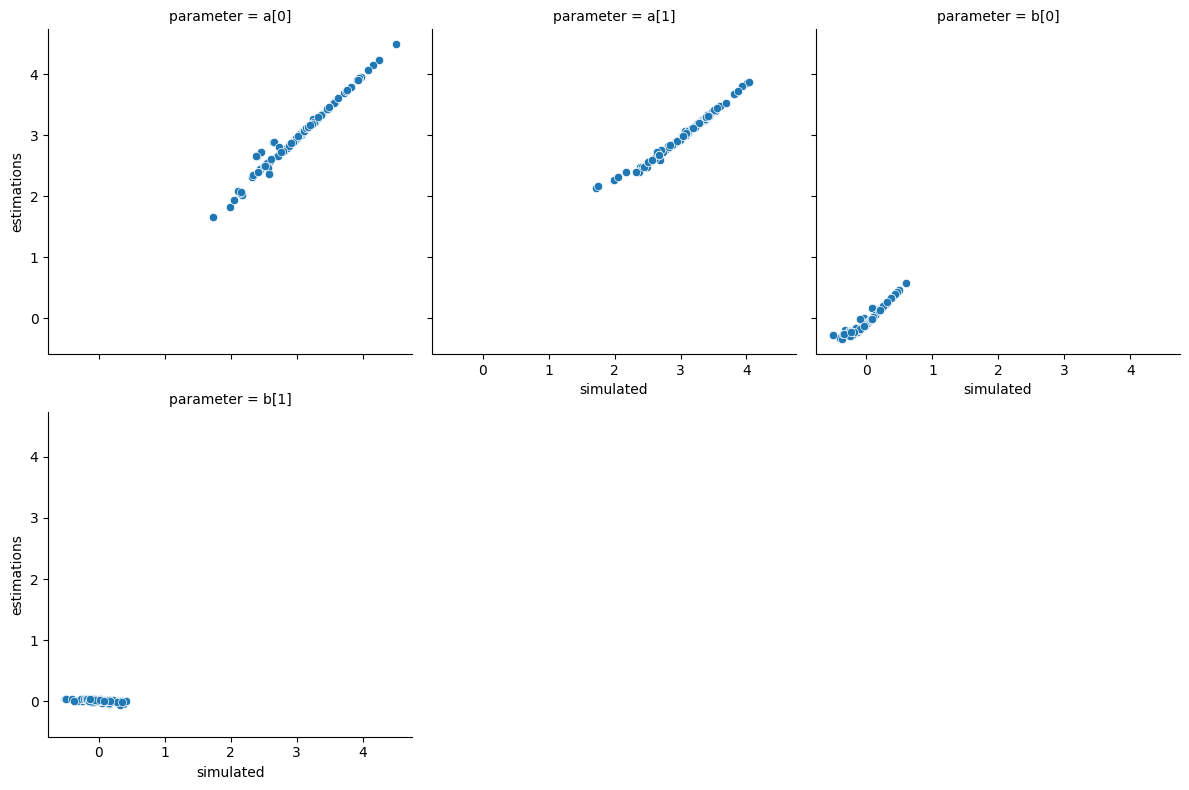

In [146]:

def model(cid, population, total_tools):
    a = dist.normal(3, 0.5, shape= (2,), name='a')
    b = dist.normal(0, 0.2, shape=(2,), name='b')
    l = jnp.exp(a[cid] + b[cid]*population)
    lk("y", Poisson(l), obs=total_tools)

def sim_total_tools(cid, population, a, b):
    l = jnp.exp(a[cid] + b[cid]*population)
    return dist.poisson(l, sample=True)

def estimate(cid, population, a, b):
    total_tools = sim_total_tools(cid, population, a, b) # Simulate data
    # Run model
    m = bi(platform='cpu')
    m.df = pd.DataFrame({"cid": cid, 'population' : population, "total_tools": total_tools})
    #m.scale(['blooms', 'shade', 'blooms'])
    m.run(model, num_samples=500, progress_bar=False) 
    s = m.summary()
    return s.iloc[:,0]

def plot_recovery(res):
    g = sns.FacetGrid(res, col="parameter", col_wrap=3, height=4)
    res['simulated'] = res['simulated'].astype(float)
    res['estimations'] = res['estimations'].astype(float)
    g.map(sns.scatterplot, "simulated", "estimations")

def param_recovery(cid, population, a, b, nsim):
    df = pd.DataFrame(columns=['sim', 'parameter', 'simulated', 'estimations'])

    for i in range(nsim):
        estimations = estimate(cid, population,a[i], b[i])
        data = {'sim': np.repeat(i, len(estimations.index.values)), 
                'parameter': estimations.index.values, 
                'simulated' : jnp.concatenate([a[i], b[i]]), 
                'estimations': estimations.values}
        df = pd.concat([df, pd.DataFrame(data)], axis = 0, ignore_index=True)

    plot_recovery(df)    

    return df

nsim = 100
cid = m.df.cid.values
population = m.df.population.values
a = dist.normal(3, 0.5, shape= (nsim, 2,), name='a', sample=True, seed = 1)
b = dist.normal(0, 0.2, shape=(nsim, 2,), name='b', sample=True, seed = 2)
result = param_recovery(cid, population, a, b, nsim)

## <a id='toc2_7_'></a>[7. Negative binomial (model 11.12) (PB estimation)](#toc0_)

### <a id='toc2_7_1_'></a>[Simulated data](#toc0_)

In [7]:
import tensorflow_probability.substrates.jax.distributions as tfd
import pandas as pd
init_key, sample_key = random.split(random.PRNGKey(int(r.randint(0, 10000000))))
init_key = jnp.array(init_key)
num_days = 30
y = tfd.Poisson(rate=1.5).sample(seed = init_key, sample_shape=(num_days,))
num_weeks = 4
y_new = tfd.Poisson(rate=0.5 * 7).sample(seed = init_key, sample_shape=(num_weeks,))
y_all = np.concatenate([y, y_new])
exposure = np.concatenate([np.repeat(1, 30), np.repeat(7, 4)])
monastery = np.concatenate([np.repeat(0, 30), np.repeat(1, 4)])
d = pd.DataFrame.from_dict(dict(y=y_all, days=exposure, monastery=monastery))
d["log_days"] = d.days.pipe(np.log)
d.to_csv('../resources/data/Sim dat Gamma poisson.csv', index=False)

### <a id='toc2_7_2_'></a>[BI](#toc0_)

In [183]:
from main import*
# setup platform------------------------------------------------
m = bi()
m.data('../resources/data/Sim dat Gamma poisson.csv', sep=',') 
def model(log_days, monastery, y):
    a = dist.normal(0, 1, name = 'a')
    b = dist.normal(0, 1, name = 'b')
    l = log_days + a +  b * monastery
    lk("y", Poisson(rate = l), obs=y)

# Run sampler ------------------------------------------------
m.run(model, num_warmup = 1000, num_samples=1000) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 2000/2000 [00:01<00:00, 1916.23it/s, 3 steps of size 8.72e-01. acc. prob=0.91]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      1.18      0.19      1.16      0.87      1.48    758.91      1.00
         b     -0.27      0.67     -0.31     -1.19      0.98    632.05      1.01

Number of divergences: 0


### <a id='toc2_7_3_'></a>[STAN](#toc0_)

In [184]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()

stan_code =""" 
data{
    array[34] int y;
    array[34] int monastery;
    vector[34] log_days;
}
parameters{
    real a;
    real b;
}
model{
    vector[34] lambda;
    b ~ normal( 0 , 1 );
    a ~ normal( 0 , 1 );
    for ( i in 1:34 ) {
        lambda[i] = log_days[i] + a + b * monastery[i];
        // B1 ~ exponential( 1 );
        // gamma(lambda[i]*B1, B1);
        lambda[i] = exp(lambda[i]);
    }
    
    y ~ poisson( lambda );    
}
"""

data = {
    'y' : np.array(m.data_on_model["y"].astype(int)),
    'monastery' : np.array(m.data_on_model["monastery"].astype(int)) +1,
    'log_days' : np.array(m.data_on_model["log_days"].astype(float)),
}

start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=1000, num_warmup = 1000)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...

INFO:aiohttp.access:127.0.0.1 [14/Jan/2025:15:19:47 +0100] "POST /v1/models/yi2fawvz/params HTTP/1.1" 404 250 "-" "Python/3.10 aiohttp/3.9.3"
INFO:httpstan:Building model-specific services extension module for `models/yi2fawvz`.
INFO:root:building 'stan_services_model_yi2fawvz' extension
INFO:root:creating build/temp.linux-x86_64-cpython-310/home/sosa/.cache/httpstan/4.12.0/models/yi2fawvz
INFO:root:x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -DSTAN_THREADS -D_REENTRANT -D_GLIBCXX_USE_CXX11_ABI=0 -I/home/sosa/.cache/httpstan/4.12.0/models/yi2fawvz -I/home/sosa/.local/lib/python3.10/site-packages/httpstan/include -I/usr/include/python3.10 -c /home/sosa/.cache/httpstan/4.12.0/models/yi2fawvz/model_yi2fawvz.cpp -o build/temp.linux-x86_64-cpython-310/home/sosa/.cache/httpstan/4.12.0/models/yi2fawvz/model_yi


Building: 13.5s, done.INFO:aiohttp.access:127.0.0.1 [14/Jan/2025:15:20:00 +0100] "POST /v1/models/yi2fawvz/params HTTP/1.1" 200 308 "-" "Python/3.10 aiohttp/3.9.3"
Sampling:   0%INFO:aiohttp.access:127.0.0.1 [14/Jan/2025:15:20:00 +0100] "POST /v1/models/yi2fawvz/fits HTTP/1.1" 201 274 "-" "Python/3.10 aiohttp/3.9.3"
INFO:aiohttp.access:127.0.0.1 [14/Jan/2025:15:20:01 +0100] "GET /v1/operations/2engobv5 HTTP/1.1" 200 326 "-" "Python/3.10 aiohttp/3.9.3"

Sampling: 100% (2000/2000)INFO:httpstan:Operation `operations/2engobv5` finished.
INFO:aiohttp.access:127.0.0.1 [14/Jan/2025:15:20:01 +0100] "GET /v1/operations/2engobv5 HTTP/1.1" 200 378 "-" "Python/3.10 aiohttp/3.9.3"
INFO:aiohttp.access:127.0.0.1 [14/Jan/2025:15:20:01 +0100] "GET /v1/models/yi2fawvz/fits/2engobv5 HTTP/1.1" 200 640239 "-" "Python/3.10 aiohttp/3.9.3"
INFO:aiohttp.access:127.0.0.1 [14/Jan/2025:15:20:01 +0100] "DELETE /v1/models/yi2fawvz/fits/2engobv5 HTTP/1.1" 200 153 "-" "Python/3.10 aiohttp/3.9.3"

Sampling: 100% (200

Pystan took: 13.6469 seconds


### <a id='toc2_7_4_'></a>[Output comparison](#toc0_)

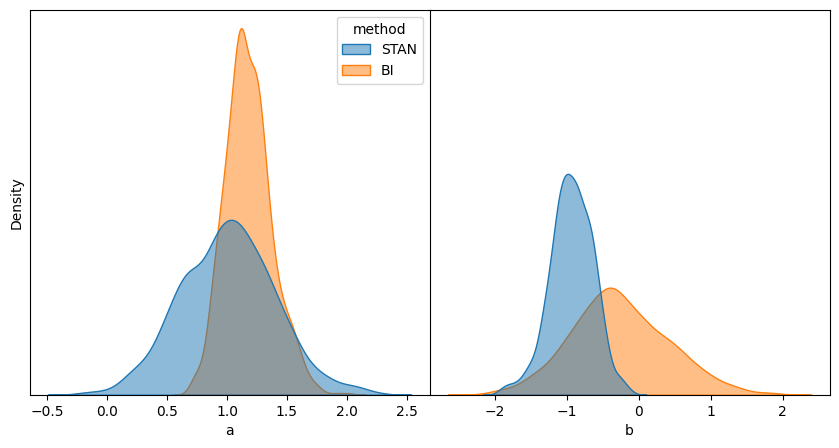

<module 'matplotlib.pyplot' from '/home/sosa/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [185]:
plot_comparaison(m, df)

### <a id='toc2_7_5_'></a>[Parameter recovery](#toc0_)

In [29]:
# setup platform------------------------------------------------
m = bi()
m.data('../resources/data/Sim dat Gamma poisson.csv', sep=',') 

def model(log_days, monastery, y):
    a = dist.normal(0, 1, name = 'a')
    b = dist.normal(0, 1, name = 'b')
    l = log_days + a +  b * monastery
    lk("y", Poisson(rate = l), obs = y)


def sim_rates(log_days, monastery, a, b):
    l = log_days + a +  b * monastery
    return dist.poisson(rate = l, sample=True)

def estimate(log_days, monastery, a, b):
    rates = sim_rates(log_days, monastery, a, b) # Simulate data
    # Run model
    m = bi(platform='cpu')
    m.df = pd.DataFrame({"log_days": log_days, "monastery": monastery, 'y': rates})
    m.run(model, num_samples=500, progress_bar=False) 
    s = m.summary()
    return s.iloc[:,0]

def plot_recovery(res):
    g = sns.FacetGrid(res, col="parameter", col_wrap=3, height=4)
    res['simulated'] = res['simulated'].astype(float)
    res['estimations'] = res['estimations'].astype(float)
    g.map(sns.scatterplot, "simulated", "estimations")

def param_recovery(log_days, monastery, a, b, nsim):
    df = pd.DataFrame(columns=['sim', 'parameter', 'simulated', 'estimations'])

    for i in range(nsim):
        estimations = estimate(log_days, monastery, a[i], b[i] )
        data = {'sim': np.repeat(i, len(estimations.index.values)), 
                'parameter': estimations.index.values, 
                'simulated' : jnp.concatenate([a[i], b[i]]), 
                'estimations': estimations.values}
        df = pd.concat([df, pd.DataFrame(data)], axis = 0, ignore_index=True)

    plot_recovery(df)    

    return df

nsim = 1
log_days = jnp.array(m.df.log_days.values)
monastery = jnp.array(m.df.monastery.values)
a = dist.normal(0, 1, name = 'a', sample=True, shape=(nsim, 1))
b = dist.normal(0, 1, name = 'b', sample=True, shape=(nsim, 1))

result = param_recovery(log_days, monastery, a, b, nsim)

jax.local_device_count 32
jax.local_device_count 32


/home/sosa/work/BI/bi/main.py:126: UserWarning: Site y: Out-of-support values provided to log prob method. The value argument should be within the support.
  self.sampler.run(jax.random.PRNGKey(seed), **self.data_on_model)


RuntimeError: Cannot find valid initial parameters. Please check your model again.

In [ ]:
import tensorflow_probability.substrates.jax.distributions as tfd
import pandas as pd
def sim_data(num_days= 30, num_weeks = 4, rate1 = 1.5, rate2 = 0.5):
    init_key, sample_key = random.split(random.PRNGKey(int(r.randint(0, 10000000))))
    init_key = jnp.array(init_key)
    y = tfd.Poisson(rate=rate1).sample(seed = init_key, sample_shape=(num_days,))
    y_new = tfd.Poisson(rate=rate2 * 7).sample(seed = init_key, sample_shape=(num_weeks,))
    y_all = np.concatenate([y, y_new])
    exposure = np.concatenate([np.repeat(1, 30), np.repeat(7, 4)])
    monastery = np.concatenate([np.repeat(0, 30), np.repeat(1, 4)])
    d = pd.DataFrame.from_dict(dict(y=y_all, days=exposure, monastery=monastery))
    d["log_days"] = d.days.pipe(np.log)
    return d


sim_data(num_days= 30, num_weeks = 4, rate1 = 1.5, rate2 = 0.5)

## <a id='toc2_8_'></a>[8. Multinomial (model 11.13) (PB estimation)](#toc0_)

### <a id='toc2_8_1_'></a>[Simulated data](#toc0_)

In [55]:
# simulate career choices among 500 individuals
N = 500  # number of individuals
income = jnp.array([1, 2, 5])  # expected income of each career
score = 0.5 * income  # scores for each career, based on income
# next line converts scores to probabilities
p = jax.nn.softmax(score)

# now simulate choice
# outcome career holds event type values, not counts
career = jnp.repeat(jnp.nan, N)  # empty vector of choices for each individual
# sample chosen career for each individual
for i in range(N):
    career = career.at[i].set(
        bi.dist.categorical(probs=p, sample=True,seed=i)
    )
career = career.astype(jnp.int32)
data = {'career': career, 'income': [income[index] for index in career]}
d = pd.DataFrame(data)
d.to_csv('../resources/data/Sim data multinomial.csv')

### <a id='toc2_8_2_'></a>[BI](#toc0_)

In [56]:
from main import*
m = bi('cpu')
df=pd.read_csv('../resources/data/Sim data multinomial.csv')
#m.data('../resources/data/Sim data multinomial.csv', sep=',') 
m.data_to_model={}
m.data_to_model['career']=jnp.array(df['career'].values)
m.data_to_model['income']=jnp.array(df['income'].unique()).astype(jnp.int32)

jax.local_device_count 32


In [103]:
a = dist.normal(0, 1, shape= (2,), name = 'a', sample = True)
b = bi.dist.halfnormal(0.5,  shape= (1,),name = 'b', sample = True)
s_1 = a[0] + b * income[0]
s_2 = a[1] + b * income[1]
s_3 = [0] #pivot
p = jax.nn.softmax(jnp.stack([s_1[0], s_2[0], s_3[0]]))
p 


Array([0.36634521, 0.22759632, 0.40605847], dtype=float64)

In [160]:
bi.categorical(probs =  p, sample = True, seed = r.randint(0, 10000000), shape=career.shape)

Array([2, 2, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 2, 0, 2, 2,
       0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 0, 2, 0, 0,
       1, 2, 2, 0, 2, 1, 2, 0, 2, 2, 2, 2, 1, 0, 2, 0, 2, 0, 1, 2, 0, 1,
       0, 2, 2, 2, 1, 1, 2, 2, 0, 1, 2, 0, 2, 2, 0, 2, 1, 1, 0, 0, 0, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 1, 2, 0, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       0, 0, 1, 0, 1, 2, 1, 1, 0, 0, 1, 0, 0, 2, 2, 0, 2, 1, 2, 2, 2, 1,
       1, 0, 2, 2, 2, 1, 0, 0, 2, 1, 0, 2, 1, 1, 2, 1, 0, 2, 2, 0, 0, 1,
       0, 1, 2, 0, 0, 2, 2, 2, 1, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2,
       1, 0, 0, 0, 2, 0, 0, 1, 2, 1, 2, 2, 2, 0, 2, 0, 1, 1, 1, 2, 2, 2,
       2, 2, 0, 2, 1, 0, 0, 0, 0, 2, 2, 0, 2, 0, 1, 1, 2, 1, 2, 2, 1, 1,
       1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 1, 1, 0, 1, 2, 1, 0, 2, 2, 1, 0,
       2, 2, 2, 2, 1, 0, 0, 1, 0, 2, 2, 0, 2, 0, 2, 2, 2, 1, 2, 2, 1, 2,
       2, 2, 1, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 1,

In [60]:
from main import*
import pandas as pd
m = bi('cpu')
df=pd.read_csv('../resources/data/Sim data multinomial.csv')
#m.data('../resources/data/Sim data multinomial.csv', sep=',') 
m.data_on_model={}
m.data_on_model['career']=jnp.array(df.career.values)
m.data_on_model['income']=jnp.array(df.income.unique()).astype(jnp.int32)
def model(career, income ):
    a = dist.normal(0, 1, shape= (2,), name = 'a')
    b = bi.dist.halfnormal(0.5,  shape= (1,),name = 'b')
    s_1 = a[0] + b * income[0]
    s_2 = a[1] + b * income[1]
    s_3 = [0] #pivot
    p = jax.nn.softmax(jnp.stack([s_1[0], s_2[0], s_3[0]]))
    lk("y", Categorical(probs =  p[career]), obs=career)

# Run sampler ------------------------------------------------ 
m.run(model)  

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:01<00:00, 821.35it/s, 7 steps of size 4.72e-01. acc. prob=0.92]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     -4.72      0.44     -4.71     -5.44     -4.07    377.11      1.00
      a[1]     -1.66      0.13     -1.66     -1.88     -1.46    198.69      1.00
      b[0]      0.04      0.03      0.03      0.00      0.08    259.29      1.01

Number of divergences: 0


In [63]:
m.data_on_model['income']

Array([5, 2, 1], dtype=int32)

In [61]:
post = m.sampler.get_samples()
# set up logit scores
s1 = post["a"][:, 0][0] + post["b"][:, 0] * income[0]
s2_orig = post["a"][:, 1] + post["b"][:, 0] * income[1]
s2_new = post["a"][:, 1] + post["b"][:, 0] * income[1] * 2

# compute probabilities for original and counterfactual
p_orig = vmap(lambda s1, s2: jax.nn.softmax(jnp.stack([s1, s2, 0])))(s1, s2_orig)
p_new = vmap(lambda s1, s2: jax.nn.softmax(jnp.stack([s1, s2, 0])))(s1, s2_new)# summarize
p_diff = p_new[:, 1] - p_orig[:, 1]
print(jnp.std(p_diff))
jnp.mean(p_diff)

0.009655473669370137


Array(0.01043036, dtype=float64)

### <a id='toc2_8_3_'></a>[STAN](#toc0_)

In [62]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()

stan_code =""" 
data{
    int N; // number of individuals
    int K; // number of possible careers
    array[N] int career; // outcome
    vector[K] career_income;
}
parameters{
    vector[K-1] a; // intercepts
    real<lower=0> b; // association of income with choice
}
model{
    vector[K] p;
    vector[K] s;
    a ~ normal( 0 , 1 );
    b ~ normal( 0 , 0.5 );
    s[1] = a[1] + b*career_income[1];
    s[2] = a[2] + b*career_income[2];
    s[3] = 0; // pivot
    p = softmax( s );
    career ~ categorical( p );
}
"""

data = {
    'N' : 500,
    'K' : 3,
    'career' : df["career"].values.astype(int) + 1,
    'career_income' : df["income"].unique().astype(int).tolist(),
}

start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...

INFO:aiohttp.access:127.0.0.1 [14/Jan/2025:13:51:08 +0100] "POST /v1/models/s6kbv2l5/params HTTP/1.1" 404 250 "-" "Python/3.10 aiohttp/3.9.3"
INFO:httpstan:Building model-specific services extension module for `models/s6kbv2l5`.
INFO:root:building 'stan_services_model_s6kbv2l5' extension
INFO:root:x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -DSTAN_THREADS -D_REENTRANT -D_GLIBCXX_USE_CXX11_ABI=0 -I/home/sosa/.cache/httpstan/4.12.0/models/s6kbv2l5 -I/home/sosa/.local/lib/python3.10/site-packages/httpstan/include -I/usr/include/python3.10 -c /home/sosa/.cache/httpstan/4.12.0/models/s6kbv2l5/model_s6kbv2l5.cpp -o build/temp.linux-x86_64-cpython-310/home/sosa/.cache/httpstan/4.12.0/models/s6kbv2l5/model_s6kbv2l5.o -O3 -std=c++14 -Wno-sign-compare
INFO:root:x86_64-linux-gnu-g++ -shared -Wl,-O1 -Wl,-Bsymbolic-


Building: 14.0s, done.INFO:aiohttp.access:127.0.0.1 [14/Jan/2025:13:51:22 +0100] "POST /v1/models/s6kbv2l5/params HTTP/1.1" 200 318 "-" "Python/3.10 aiohttp/3.9.3"
Sampling:   0%INFO:aiohttp.access:127.0.0.1 [14/Jan/2025:13:51:22 +0100] "POST /v1/models/s6kbv2l5/fits HTTP/1.1" 201 274 "-" "Python/3.10 aiohttp/3.9.3"
INFO:aiohttp.access:127.0.0.1 [14/Jan/2025:13:51:22 +0100] "GET /v1/operations/fhqlfnq5 HTTP/1.1" 200 326 "-" "Python/3.10 aiohttp/3.9.3"

Sampling: 100% (1000/1000)INFO:httpstan:Operation `operations/fhqlfnq5` finished.
INFO:aiohttp.access:127.0.0.1 [14/Jan/2025:13:51:22 +0100] "GET /v1/operations/fhqlfnq5 HTTP/1.1" 200 378 "-" "Python/3.10 aiohttp/3.9.3"
INFO:aiohttp.access:127.0.0.1 [14/Jan/2025:13:51:22 +0100] "GET /v1/models/s6kbv2l5/fits/fhqlfnq5 HTTP/1.1" 200 378816 "-" "Python/3.10 aiohttp/3.9.3"
INFO:aiohttp.access:127.0.0.1 [14/Jan/2025:13:51:22 +0100] "DELETE /v1/models/s6kbv2l5/fits/fhqlfnq5 HTTP/1.1" 200 153 "-" "Python/3.10 aiohttp/3.9.3"

Sampling: 100% (100

Pystan took: 14.2019 seconds


### <a id='toc2_8_4_'></a>[Output comparison](#toc0_)

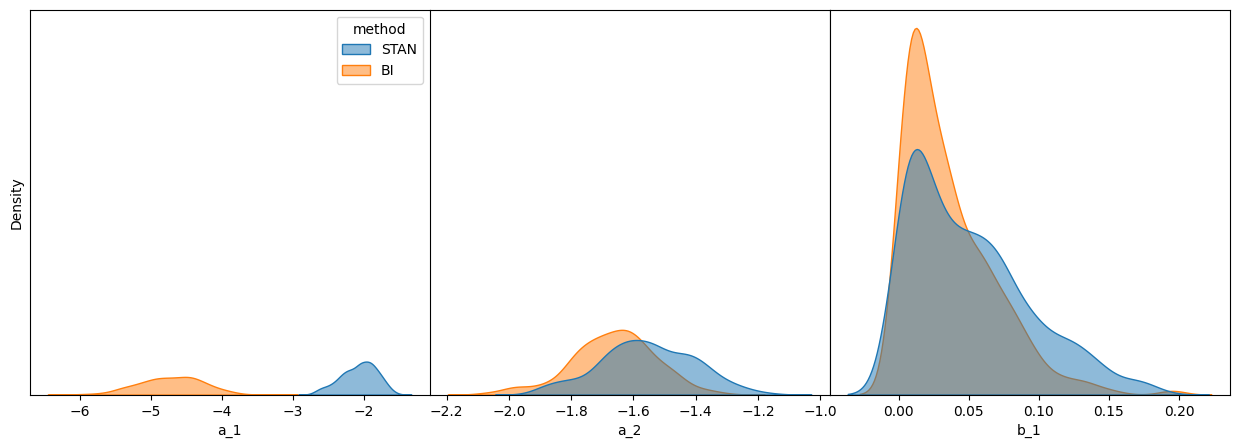

<module 'matplotlib.pyplot' from '/home/sosa/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [65]:
plot_comparaison(m, df)

### <a id='toc2_8_5_'></a>[Parameter recovery](#toc0_)

In [ ]:
from main import *
import pandas as pd
m = bi()
m.data('resources/data/Sim data multinomial.csv', sep=',') 

def model(income, career):
    a = dist.normal(0, 1, shape= [2], name = 'a')
    b = bi.dist.normal(0, 0.5, shape=[1], name = 'b')
    s_1 = a[0] + b * income[0]
    s_2 = a[1] + b * income[1]
    s_3 = [0] #pivot
    p = jax.nn.softmax(jnp.stack([s_1[0], s_2[0], s_3[0]]))
    lk("y", Categorical(probs =  p[career]), obs=career)

def sim_total_tools(income, career, a, b):
    s_1 = a[0] + b * income[0]
    s_2 = a[1] + b * income[1]
    s_3 = [0] #pivot
    p = jax.nn.softmax(jnp.stack([s_1[0], s_2[0], s_3[0]]))

    return dist.categorical(probs =  p[career], sample=True)

def estimate(income, career, a, b):
    career = sim_total_tools(income, career, a, b) # Simulate data
    # Run model
    m = bi(platform='cpu')
    m.df = pd.DataFrame({"career": career, 'income' : income, "career": career})
    #m.scale(['blooms', 'shade', 'blooms'])
    m.run(model, num_samples=500, progress_bar=False) 
    s = m.summary()
    return s.iloc[:,0]

def plot_recovery(res):
    g = sns.FacetGrid(res, col="parameter", col_wrap=3, height=4)
    res['simulated'] = res['simulated'].astype(float)
    res['estimations'] = res['estimations'].astype(float)
    g.map(sns.scatterplot, "simulated", "estimations")

def param_recovery(income, career, a, b, nsim):
    df = pd.DataFrame(columns=['sim', 'parameter', 'simulated', 'estimations'])

    for i in range(nsim):
        estimations = estimate(income, career,a[i], b[i])
        data = {'sim': np.repeat(i, len(estimations.index.values)), 
                'parameter': estimations.index.values, 
                'simulated' : jnp.concatenate([a[i], b[i]]), 
                'estimations': estimations.values}
        df = pd.concat([df, pd.DataFrame(data)], axis = 0, ignore_index=True)

    plot_recovery(df)    

    return df

m = bi()
m.data('resources/data/Sim data multinomial.csv', sep=',') 
nsim = 10
income = jnp.unique(m.df.income.values)
career = jnp.array(m.df.career.values)
a = dist.normal(0, 1, shape= (nsim,2), name = 'a', sample=True)
b = bi.dist.normal(0, 0.5, shape=(nsim,1), name = 'b', sample=True)
result = param_recovery(income, career, a, b, nsim)

## <a id='toc2_9_'></a>[9. Beta binomial (model m12.1)](#toc0_)

### <a id='toc2_9_1_'></a>[BI](#toc0_)

In [14]:
# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------
m.data('../resources/data/UCBadmit.csv', sep=';') 
m.df["gid"] = (m.df["applicant.gender"] != "male").astype(int)
#gid = jnp.array(m.df["gid"].astype('int32').values)
#applications = jnp.array(m.df["applications"].astype('float32').values)
#admit = jnp.array(m.df["admit"].astype('float32').values)
#
#m.data_on_model = dict(
#    gid = gid,
#    applications = applications,
#    admit =  admit
#)

def model(gid, applications, admit):
    phi = dist.exponential(1, shape=[1], name = 'phi')
    alpha = dist.normal( 0., 1.5, shape=[2], name = 'alpha')
    theta = numpyro.deterministic('theta', phi + 2)
    pbar = jax.nn.sigmoid(alpha[gid])
    concentration1 = pbar*theta
    concentration0 = (1 - pbar) * theta
    lk("y", BetaBinomial(total_count = applications, concentration1 = concentration1, concentration0 = concentration0), obs=admit)

# Run sampler ------------------------------------------------
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 16


sample: 100%|██████████| 1000/1000 [00:03<00:00, 268.12it/s, 7 steps of size 5.21e-01. acc. prob=0.88]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
  alpha[0]     -0.46      0.43     -0.41     -1.19      0.14    376.14      1.00
  alpha[1]     -0.29      0.42     -0.29     -1.03      0.27    402.99      1.01
    phi[0]      0.97      0.75      0.78      0.01      1.90    458.95      1.00

Number of divergences: 0


### <a id='toc2_9_2_'></a>[STAN](#toc0_)

In [166]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()
stan_code =""" 
data{
    array[12] int N;
    array[12] int A;
    array[12] int gid;
}
parameters{
    vector[2] a;
    real<lower=0> phi;
}
transformed parameters{
    real theta;
    theta = phi + 2;
}
model{
    vector[12] pbar;
    phi ~ exponential( 1 );
    a ~ normal( 0 , 1.5 );
    for ( i in 1:12 ) {
        pbar[i] = a[gid[i]];
        pbar[i] = inv_logit(pbar[i]);
    }
    A ~ beta_binomial( N , pbar*theta , (1-pbar)*theta );    
}
"""

data = {
    'A' : m.df["admit"].values.astype(int),
    'N' : m.df["applications"].values.astype(int),
    'gid' : m.df["gid"].values.astype(int) +1,
}

start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: 12.7s, done.Sampling:   0%
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!


Pystan took: 12.8776 seconds


### <a id='toc2_9_3_'></a>[Output comparison](#toc0_)

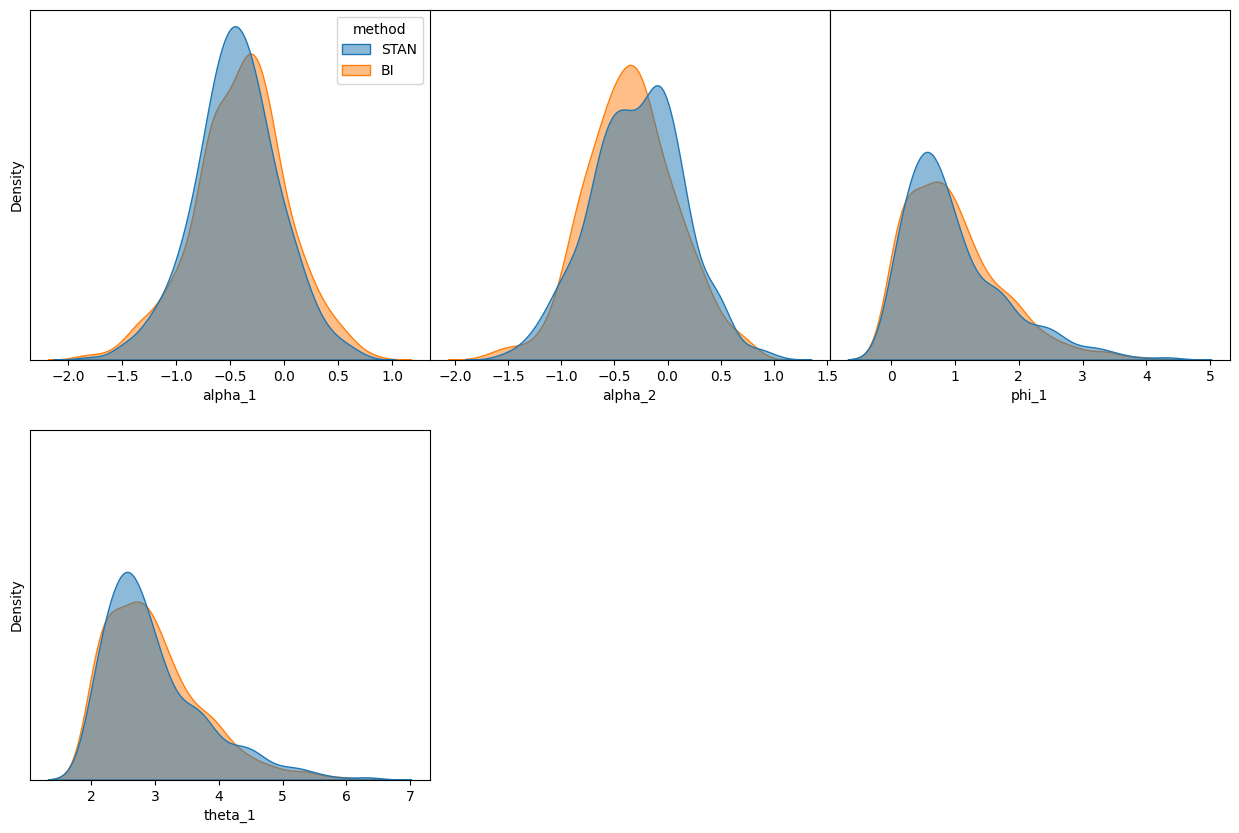

<module 'matplotlib.pyplot' from '/home/sosa/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [167]:
plot_comparaison(m, df)

## <a id='toc2_10_'></a>[10. Negative-binomial](#toc0_)

### <a id='toc2_10_1_'></a>[BI](#toc0_)

In [15]:
# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------
m.data('../resources/data/UCBadmit.csv', sep=';') 
m.df["gid"] = (m.df["applicant.gender"] != "male").astype(int)
#gid = jnp.array(m.df["gid"].astype('int32').values)
#applications = jnp.array(m.df["applications"].astype('float32').values)
#admit = jnp.array(m.df["admit"].astype('float32').values)
#
#m.data_on_model = dict(
#    gid = gid,
#    applications = applications,
#    admit =  admit
#)

def model(gid, applications, admit):
    phi = dist.exponential(1, shape=[1], name = 'phi')
    alpha = dist.normal(0., 1.5, shape=[2], name = 'alpha')
    theta = phi + 2
    pbar = jax.nn.sigmoid(alpha[gid])
    concentration1 = pbar*theta
    concentration0 = (1 - pbar) * theta
    lk("y", BetaBinomial(total_count = applications, concentration1 = concentration1, concentration0 = concentration0), obs=admit)

# Run sampler ------------------------------------------------
m.run(model) 


# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 16


sample: 100%|██████████| 1000/1000 [00:04<00:00, 228.69it/s, 7 steps of size 5.21e-01. acc. prob=0.88]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
  alpha[0]     -0.46      0.43     -0.41     -1.19      0.14    376.14      1.00
  alpha[1]     -0.29      0.42     -0.29     -1.03      0.27    402.99      1.01
    phi[0]      0.97      0.75      0.78      0.01      1.90    458.95      1.00

Number of divergences: 0


### <a id='toc2_10_2_'></a>[STAN](#toc0_)

## <a id='toc2_11_'></a>[11. Zero inflated outcomes](#toc0_)

### <a id='toc2_11_1_'></a>[BI](#toc0_)

In [175]:
from jax.scipy.special import expit
r.seed(42)
# Define parameters
prob_drink = 0.2  # 20% of days
rate_work = 1     # average 1 manuscript per day

# sample one year of production
N = 365

np.random.seed(365)
drink = np.random.binomial(1, prob_drink, N)
y = (1 - drink) * np.random.poisson(rate_work, N)
d = pd.DataFrame(y)
# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------

m.data_on_model = dict(
    y = jnp.array(y)
)

def model(y):
    ap = dist.normal( -1.5, 1, [1], name = 'ap')
    p = expit(ap)

    al = dist.normal( 1, 0.5, [1] , name = 'al')
    lambda_ = jnp.exp(al)    
    
    lk("y", ZeroInflatedPoisson(p, lambda_), obs=y)

# Run sampler ------------------------------------------------
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1022.10it/s, 7 steps of size 5.16e-01. acc. prob=0.92]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        al      0.11      0.08      0.11     -0.03      0.24    142.09      1.00
        ap     -1.37      0.37     -1.32     -1.86     -0.79    143.04      1.00

Number of divergences: 0


In [177]:
m.posteriors.keys()

dict_keys(['al', 'ap'])

### <a id='toc2_11_2_'></a>[STAN](#toc0_)

In [178]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()
stan_code = """ 
data{
    array[365] int y;
}
parameters{
    real al;
    real ap;
    
}
model{
    real p;
    real lambda;
    al ~ normal( 1 , 0.5 );
    ap ~ normal( -1.5 , 1 );   
    
    lambda = al;
    lambda = exp(lambda);
    p = ap;
    p = inv_logit(p);
    for ( i in 1:365 ) {
        if ( y[i]==0 )
            target += log_mix( p , 0 , poisson_lpmf(0|lambda) );
        if ( y[i] > 0 )
            target += log1m( p ) + poisson_lpmf(y[i] | lambda );
    }
}
"""
data = {
    'y' :d.iloc[:,0].values.astype(int)
}
start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...

INFO:aiohttp.access:127.0.0.1 [14/Jan/2025:15:16:51 +0100] "POST /v1/models/qatnz6uu/params HTTP/1.1" 404 250 "-" "Python/3.10 aiohttp/3.9.3"
INFO:httpstan:Building model-specific services extension module for `models/qatnz6uu`.
INFO:root:building 'stan_services_model_qatnz6uu' extension
INFO:root:creating build/temp.linux-x86_64-cpython-310/home/sosa/.cache/httpstan/4.12.0/models/qatnz6uu
INFO:root:x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -DSTAN_THREADS -D_REENTRANT -D_GLIBCXX_USE_CXX11_ABI=0 -I/home/sosa/.cache/httpstan/4.12.0/models/qatnz6uu -I/home/sosa/.local/lib/python3.10/site-packages/httpstan/include -I/usr/include/python3.10 -c /home/sosa/.cache/httpstan/4.12.0/models/qatnz6uu/model_qatnz6uu.cpp -o build/temp.linux-x86_64-cpython-310/home/sosa/.cache/httpstan/4.12.0/models/qatnz6uu/model_qa


Building: 12.4s, done.INFO:aiohttp.access:127.0.0.1 [14/Jan/2025:15:17:04 +0100] "POST /v1/models/qatnz6uu/params HTTP/1.1" 200 312 "-" "Python/3.10 aiohttp/3.9.3"
Sampling:   0%INFO:aiohttp.access:127.0.0.1 [14/Jan/2025:15:17:04 +0100] "POST /v1/models/qatnz6uu/fits HTTP/1.1" 201 274 "-" "Python/3.10 aiohttp/3.9.3"
INFO:aiohttp.access:127.0.0.1 [14/Jan/2025:15:17:04 +0100] "GET /v1/operations/tv43diy4 HTTP/1.1" 200 323 "-" "Python/3.10 aiohttp/3.9.3"

Sampling:   0% (1/1000)INFO:aiohttp.access:127.0.0.1 [14/Jan/2025:15:17:04 +0100] "GET /v1/operations/tv43diy4 HTTP/1.1" 200 323 "-" "Python/3.10 aiohttp/3.9.3"

Sampling:  30% (300/1000)INFO:aiohttp.access:127.0.0.1 [14/Jan/2025:15:17:04 +0100] "GET /v1/operations/tv43diy4 HTTP/1.1" 200 326 "-" "Python/3.10 aiohttp/3.9.3"

Sampling: 100% (1000/1000)INFO:httpstan:Operation `operations/tv43diy4` finished.
INFO:aiohttp.access:127.0.0.1 [14/Jan/2025:15:17:04 +0100] "GET /v1/operations/tv43diy4 HTTP/1.1" 200 378 "-" "Python/3.10 aiohttp/3.9

Pystan took: 12.7397 seconds


### <a id='toc2_11_3_'></a>[Output comparison](#toc0_)

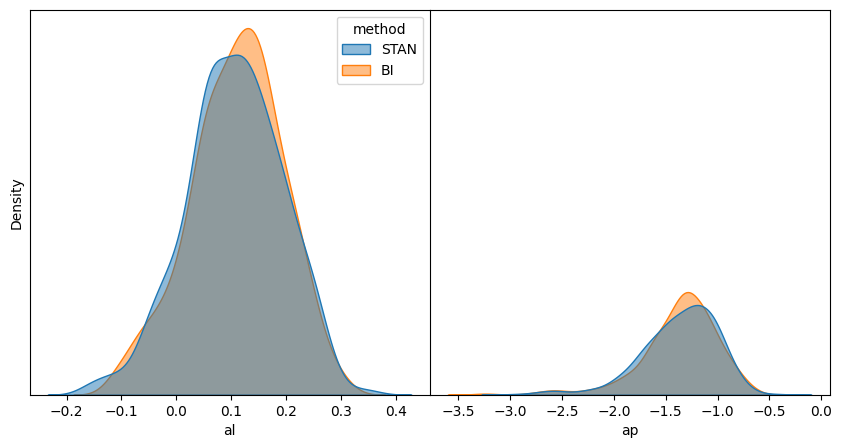

<module 'matplotlib.pyplot' from '/home/sosa/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [182]:
plot_comparaison(m, df)

## <a id='toc2_12_'></a>[12. OrderedLogistic (Todo: PB)](#toc0_)

In [172]:
#import numpyro.distributions as dist
## setup platform------------------------------------------------
#m = bi()
## import data ------------------------------------------------
#m.data('resources/data/Trolley.csv', sep=';') 
#d = m.df
## discrete proportion of each response value
#pr_k = d.response.value_counts().sort_index().values / d.shape[0]
## cumsum converts to cumulative proportions
#cum_pr_k = jnp.cumsum(pr_k, -1)
#logit = lambda x: jnp.log(x / (1 - x))  # convenience function
#lco = logit(cum_pr_k)

In [173]:
#import numpyro.distributions as distnp
#from numpyro.distributions.transforms import OrderedTransform
## setup platform------------------------------------------------
#m = bi()
#m.data_on_model = dict(response = jnp.array(d.response.values - 1))
#def model(response):
#    cutpoints = numpyro.sample(
#        
#        distnp.TransformedDistribution("cutpoints",
#            distnp.Normal(0, 1.5), OrderedTransform()
#        ),
#    )
#    numpyro.sample("R", dist.OrderedLogistic(0, cutpoints), obs=response)
#
## Run sampler ------------------------------------------------
#start = tm.time()    
#m.run(model) 
#end = tm.time()    
#print(f"BI took: {end - start:.4f} seconds")
#
## Diagnostic ------------------------------------------------
#m.sampler.print_summary(0.89)

## <a id='toc2_13_'></a>[13. Varying interceps](#toc0_)

### <a id='toc2_13_1_'></a>[BI](#toc0_)

In [16]:
# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------
m.data('../resources/data/reedfrogs.csv', sep=';') 
m.df["tank"] = np.arange(m.df.shape[0])
#tank = jnp.array(m.df["tank"].astype('int32').values)
#density = jnp.array(m.df["density"].astype('float32').values)
#surv = jnp.array(m.df["surv"].astype('int32').values)
#m.data_on_model = dict(
#    tank = tank,
#    surv = surv
#)

def model(tank, surv, density):
    sigma = dist.exponential( 1, shape = [1], name = 'sigma')
    a_bar = dist.normal( 0., 1.5, shape= [1], name = 'a_bar')
    alpha = dist.normal( a_bar, sigma, shape= tank.shape, name = 'alpha')
    p = alpha[tank]
    lk("y", Binomial(total_count = density, logits = p), obs=surv)

# Run sampler ------------------------------------------------
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 16


sample: 100%|██████████| 1000/1000 [00:02<00:00, 414.20it/s, 7 steps of size 4.83e-01. acc. prob=0.85]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
  a_bar[0]      1.34      0.25      1.33      0.94      1.69    481.30      1.00
  alpha[0]      2.09      0.87      2.02      0.78      3.40    686.28      1.00
  alpha[1]      3.05      1.03      2.92      1.48      4.59    531.37      1.00
  alpha[2]      0.99      0.66      0.94     -0.02      2.11    935.28      1.00
  alpha[3]      3.13      1.27      2.99      1.31      5.02    410.93      1.00
  alpha[4]      2.08      0.87      2.02      0.67      3.32    458.65      1.00
  alpha[5]      2.15      0.91      2.13      0.63      3.50    631.15      1.00
  alpha[6]      3.08      1.09      2.99      1.34      4.69    402.84      1.00
  alpha[7]      2.14      0.88      2.08      0.66      3.37    433.44      1.00
  alpha[8]     -0.14      0.62     -0.13     -1.08      0.87   1004.22      1.00
  alpha[9]      2.11      0.84      2.09      0.58      3.26    952.86      1.00
 alpha[10]      0.98      0

### <a id='toc2_13_2_'></a>[STAN](#toc0_)

In [56]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()
stan_code = """ 
data{
    array[48] int N;
    array[48] int S;
    array[48] int tank;
}
parameters{
    real a_bar;
    vector[48] a;    
    real<lower=0> sigma;
}
model{
    vector[48] p;
    sigma ~ exponential( 1 );
    a_bar ~ normal( 0 , 1.5 );
    a ~ normal( a_bar , sigma );
    for ( i in 1:48 ) {
        p[i] = a[tank[i]];
        p[i] = inv_logit(p[i]);
    }
    S ~ binomial( N , p );
}
"""
data = {
    'S' : m.df['surv'].values.astype(int),
    'N' : m.df['density'].values.astype(int),
    'tank' : m.df['tank'].values.astype(int)+1,
}
start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: 13.0s, done.Sampling:   0%
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!


Pystan took: 13.1819 seconds


### <a id='toc2_13_3_'></a>[Output comparison](#toc0_)

In [57]:
df.columns

Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'a_bar', 'a.1', 'a.2', 'a.3', 'a.4', 'a.5',
       'a.6', 'a.7', 'a.8', 'a.9', 'a.10', 'a.11', 'a.12', 'a.13', 'a.14',
       'a.15', 'a.16', 'a.17', 'a.18', 'a.19', 'a.20', 'a.21', 'a.22', 'a.23',
       'a.24', 'a.25', 'a.26', 'a.27', 'a.28', 'a.29', 'a.30', 'a.31', 'a.32',
       'a.33', 'a.34', 'a.35', 'a.36', 'a.37', 'a.38', 'a.39', 'a.40', 'a.41',
       'a.42', 'a.43', 'a.44', 'a.45', 'a.46', 'a.47', 'a.48', 'sigma'],
      dtype='object', name='parameters')

In [58]:
plot_comparaison(m, df)

<module 'matplotlib.pyplot' from '/home/sosa/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

## <a id='toc2_14_'></a>[14. Varying effects](#toc0_)

### <a id='toc2_14_1_'></a>[Data simulation](#toc0_)

In [88]:
import numpyro.distributions as dd
import pandas as pd
import os
import sys
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)

from main import *
import time as tm
# setup platform------------------------------------------------
m = bi(platform='cpu')

a = 3.5  # average morning wait time
b = -1  # average difference afternoon wait time
sigma_a = 1  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes
Mu = jnp.array([a, b])
cov_ab = sigma_a * sigma_b * rho
Sigma = jnp.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]])
jnp.array([1, 2, 3, 4]).reshape(2, 2).T
sigmas = jnp.array([sigma_a, sigma_b])  # standard deviations
Rho = jnp.array([[1, rho], [rho, 1]])  # correlation matrix

# now matrix multiply to get covariance matrix
Sigma = jnp.diag(sigmas) @ Rho @ jnp.diag(sigmas)

N_cafes = 20
seed = random.PRNGKey(5)  # used to replicate example
vary_effects = bi.dist.multivariatenormal(Mu, Sigma, shape=(N_cafes,), sample = True)
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

seed = random.PRNGKey(22)
N_visits = 10
afternoon = jnp.tile(jnp.arange(2), N_visits * N_cafes // 2)
cafe_id = jnp.repeat(jnp.arange(N_cafes), N_visits)
mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
sigma = 0.5  # std dev within cafes
wait = dist.normal(mu, sigma, sample = True)
d = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))
d.to_csv('../resources/data/Sim data multivariatenormal.csv', index=False)

jax.local_device_count 1


### <a id='toc2_14_2_'></a>[BI](#toc0_)

In [127]:
# import data ------------------------------------------------
m = bi()
m.data('../resources/data/Sim data multivariatenormal.csv', sep = ',')

m.data_on_model = dict(
    cafe = m.df.cafe.values, 
    wait = m.df.wait.values, 
    N_cafes = len(m.df.cafe.unique()),
    afternoon = m.df.afternoon.values
)

def model(cafe, wait, N_cafes, afternoon):
    a = dist.normal(5, 2, name = 'a')
    b = dist.normal(-1, 0.5, name = 'b')
    sigma_cafe = dist.exponential(1, shape=[2], name = 'sigma_cafe')
    sigma = dist.exponential( 1, shape=[1], name = 'sigma')
    Rho = dist.lkj(2, 2, name = 'Rho')
    cov = jnp.outer(sigma_cafe, sigma_cafe) * Rho
    a_cafe_b_cafe = dist.multivariatenormal(jnp.stack([a, b]), cov, shape = [N_cafes], name = 'a_b_cafe')    

    a_cafe, b_cafe = a_cafe_b_cafe[:, 0], a_cafe_b_cafe[:, 1]
    mu = a_cafe[cafe] + b_cafe[cafe] * afternoon
    lk("y", Normal(mu, sigma), obs=wait)

# Run sampler ------------------------------------------------
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 1


sample: 100%|██████████| 1000/1000 [00:01<00:00, 601.86it/s, 15 steps of size 2.78e-01. acc. prob=0.86]



                    mean       std    median      5.5%     94.5%     n_eff     r_hat
      Rho[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
      Rho[0,1]     -0.68      0.16     -0.71     -0.91     -0.44    336.88      1.00
      Rho[1,0]     -0.68      0.16     -0.71     -0.91     -0.44    336.88      1.00
      Rho[1,1]      1.00      0.00      1.00      1.00      1.00    215.66      1.00
             a      3.56      0.23      3.56      3.19      3.90    428.76      1.00
 a_b_cafe[0,0]      2.99      0.20      2.99      2.64      3.30    502.46      1.00
 a_b_cafe[0,1]     -0.65      0.24     -0.66     -1.02     -0.28    431.25      1.00
 a_b_cafe[1,0]      2.02      0.21      2.02      1.74      2.39    555.27      1.00
 a_b_cafe[1,1]     -0.19      0.27     -0.20     -0.66      0.20    478.95      1.00
 a_b_cafe[2,0]      2.84      0.20      2.84      2.47      3.12    656.53      1.00
 a_b_cafe[2,1]     -0.67      0.23     -0.68     -1.03     -0.30

### <a id='toc2_14_3_'></a>[STAN](#toc0_)

In [90]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
import numpy as np
#try:
#  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
#except:
#  pass

nest_asyncio.apply()
stan_code = """ 
data{
    int len;
    int N_cafes;
    vector[len] wait;
    array[len] int afternoon;
    array[len] int cafe;
}

parameters{
    corr_matrix[2] Rho;
    real a;
    vector[N_cafes] a_cafe;
    real b;
    vector[N_cafes] b_cafe;      
    real<lower=0> sigma;
    vector<lower=0>[2] sigma_cafe;   
    
}
model{
    vector[len] mu;
    Rho ~ lkj_corr( 2 );
    sigma ~ exponential( 1 );
    sigma_cafe ~ exponential( 1 );
    b ~ normal( -1 , 0.5 );    
    a ~ normal( 5 , 2 );
    {
        array[N_cafes] vector[2] YY;
        vector[2] MU;
        MU = [ a , b ]';
        for ( j in 1:N_cafes ) YY[j] = [ a_cafe[j] , b_cafe[j] ]';
        YY ~ multi_normal( MU , quad_form_diag(Rho , sigma_cafe) );
    }
    for ( i in 1:len ) {
        mu[i] = a_cafe[cafe[i]] + b_cafe[cafe[i]] * afternoon[i];        
    }
    
    wait ~ normal( mu , sigma );

}
"""
data = {
    'wait' : d['wait'].values.astype(float),
    'afternoon' : d['afternoon'].values.astype(int),
    'cafe' : d['cafe'].values.astype(int)+1,
    'N_cafes' : N_cafes,
    'len' : len(d['wait'].values)
}
start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: 27.3s, done.Messages from stanc:
Warning in '/tmp/httpstan_uk2b0bol/model_lrkdaxoz.stan', line 22, column 4: It
    is suggested to reparameterize your model to replace lkj_corr with
    lkj_corr_cholesky, the Cholesky factor variant. lkj_corr tends to run
    slower, consume more memory, and has higher risk of numerical errors.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/1000)
Sampling:  20% (200/1000)
Sampling:  40% (400/1000)
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 6.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.67 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected becaus

Pystan took: 27.7466 seconds


### <a id='toc2_14_4_'></a>[Output comparison](#toc0_)

In [91]:
df.columns

Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'Rho.1.1', 'Rho.2.1', 'Rho.1.2', 'Rho.2.2',
       'a', 'a_cafe.1', 'a_cafe.2', 'a_cafe.3', 'a_cafe.4', 'a_cafe.5',
       'a_cafe.6', 'a_cafe.7', 'a_cafe.8', 'a_cafe.9', 'a_cafe.10',
       'a_cafe.11', 'a_cafe.12', 'a_cafe.13', 'a_cafe.14', 'a_cafe.15',
       'a_cafe.16', 'a_cafe.17', 'a_cafe.18', 'a_cafe.19', 'a_cafe.20', 'b',
       'b_cafe.1', 'b_cafe.2', 'b_cafe.3', 'b_cafe.4', 'b_cafe.5', 'b_cafe.6',
       'b_cafe.7', 'b_cafe.8', 'b_cafe.9', 'b_cafe.10', 'b_cafe.11',
       'b_cafe.12', 'b_cafe.13', 'b_cafe.14', 'b_cafe.15', 'b_cafe.16',
       'b_cafe.17', 'b_cafe.18', 'b_cafe.19', 'b_cafe.20', 'sigma',
       'sigma_cafe.1', 'sigma_cafe.2'],
      dtype='object', name='parameters')

In [92]:
m.posteriors.keys()

dict_keys(['Rho', 'a', 'a_b_cafe', 'b', 'sigma', 'sigma_cafe'])

In [132]:
def slice_array_to_dict(array, name="slice"):

    _, dim2, dim3 = array.shape
    
    # Create the dictionary
    slices_dict = {
        f"{name}_{i}_{j}": array[:, i, j]
        for i in range(dim2)
        for j in range(dim3)
    }
    
    return slices_dict
def slice_array_to_dict_2(array, name="slice"):

    _, dim2  = array.shape
    
    # Create the dictionary
    slices_dict = {
        f"{name}_{i}": array[:, i]
        for i in range(dim2)
    }
    
    return slices_dict

r = slice_array_to_dict(m.posteriors['Rho'], name="Rho")
a = dict(a=m.posteriors['a'])
b = dict(b=m.posteriors['b'])
sigma = dict(sigma=m.posteriors['sigma'])
a_cafe = slice_array_to_dict_2(m.posteriors['a_b_cafe'][:,:,0], name="a_cafe")
b_cafe = slice_array_to_dict_2(m.posteriors['a_b_cafe'][:,:,1], name="b_cafe")
sigma_cafe_1 = dict(sigma_cafe_1=m.posteriors['sigma_cafe'][:, 0])
sigma_cafe_2 = dict(sigma_cafe_2=m.posteriors['sigma_cafe'][:, 1])

In [133]:
r.update(a)
r.update(a_cafe)
r.update(b)
r.update(b_cafe)
r.update(sigma)
r.update(sigma_cafe_1)
r.update(sigma_cafe_2)

In [134]:
m.posteriors=r

In [159]:
d = prepare_stan_data(df)
d.columns

Index(['Rho.1.1', 'Rho.2.1', 'Rho.1.2', 'Rho.2.2', 'a', 'a_cafe.1', 'a_cafe.2',
       'a_cafe.3', 'a_cafe.4', 'a_cafe.5', 'a_cafe.6', 'a_cafe.7', 'a_cafe.8',
       'a_cafe.9', 'a_cafe.10', 'a_cafe.11', 'a_cafe.12', 'a_cafe.13',
       'a_cafe.14', 'a_cafe.15', 'a_cafe.16', 'a_cafe.17', 'a_cafe.18',
       'a_cafe.19', 'a_cafe.20', 'b', 'b_cafe.1', 'b_cafe.2', 'b_cafe.3',
       'b_cafe.4', 'b_cafe.5', 'b_cafe.6', 'b_cafe.7', 'b_cafe.8', 'b_cafe.9',
       'b_cafe.10', 'b_cafe.11', 'b_cafe.12', 'b_cafe.13', 'b_cafe.14',
       'b_cafe.15', 'b_cafe.16', 'b_cafe.17', 'b_cafe.18', 'b_cafe.19',
       'b_cafe.20', 'sigma', 'sigma_cafe.1', 'sigma_cafe.2'],
      dtype='object', name='parameters')

/tmp/ipykernel_560721/2360528611.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_bi[col], label=f'bi_{col}', fill=True)
/tmp/ipykernel_560721/2360528611.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(d[col], label=f'stan_{col}', fill=True)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


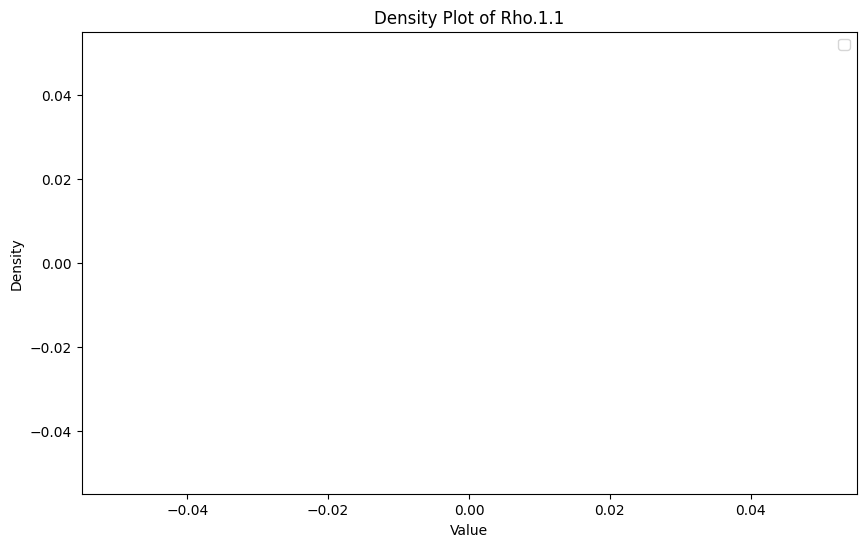

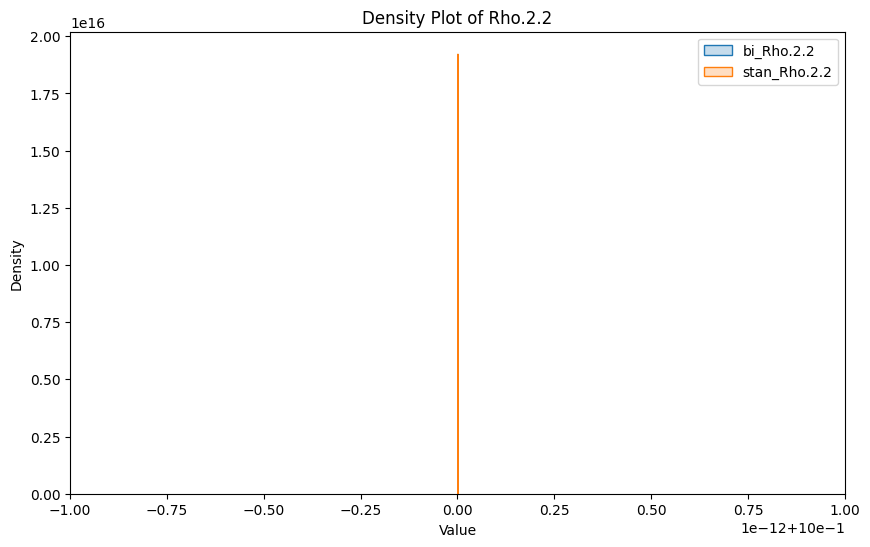

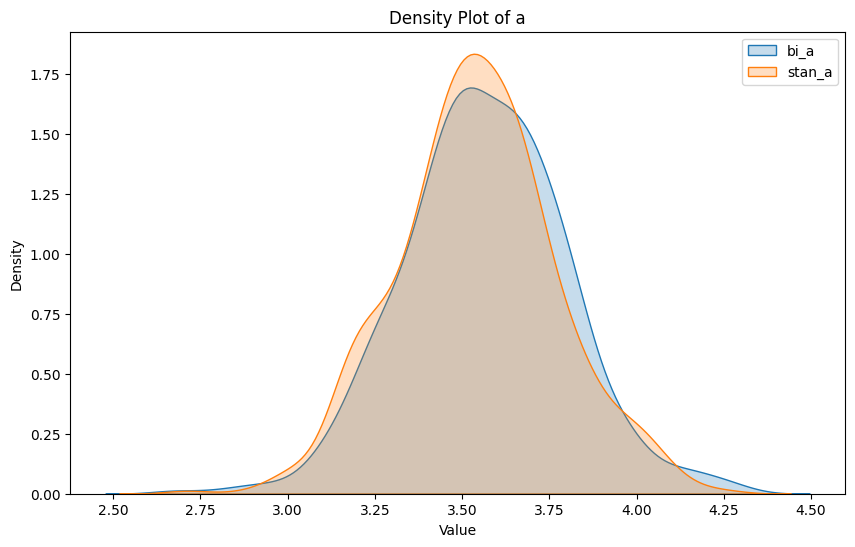

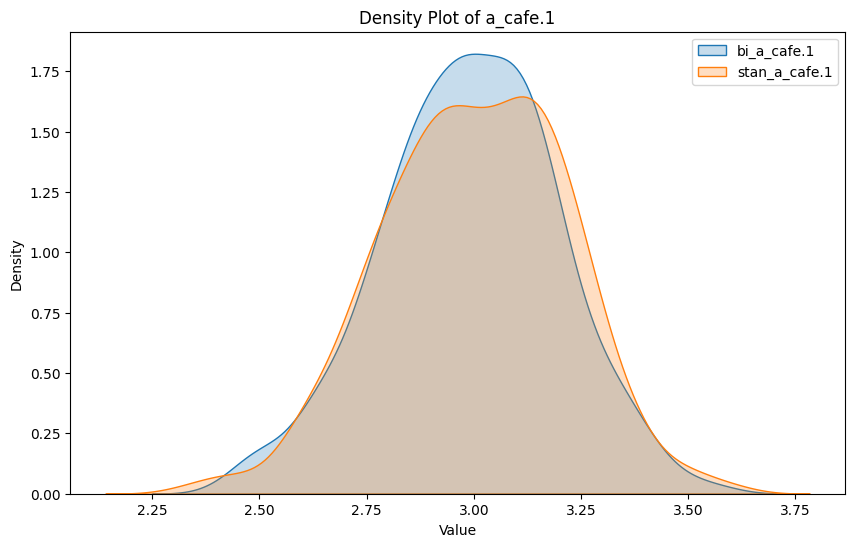

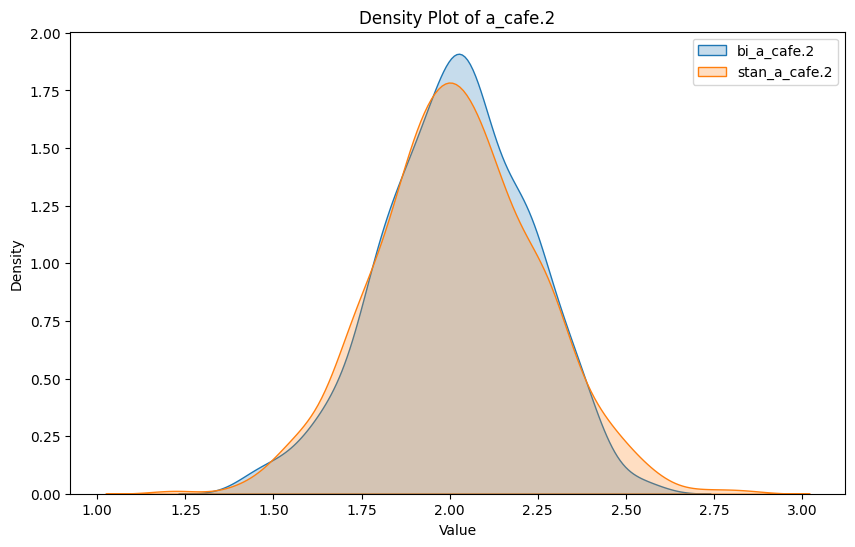

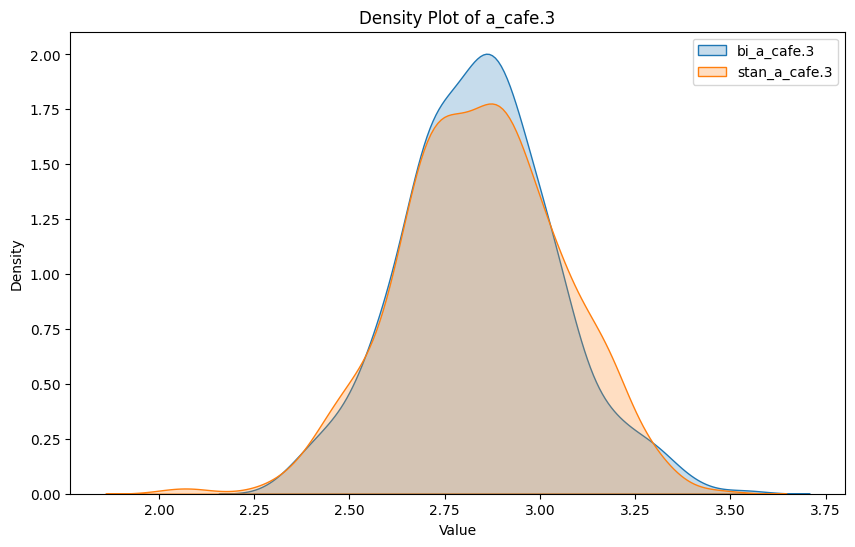

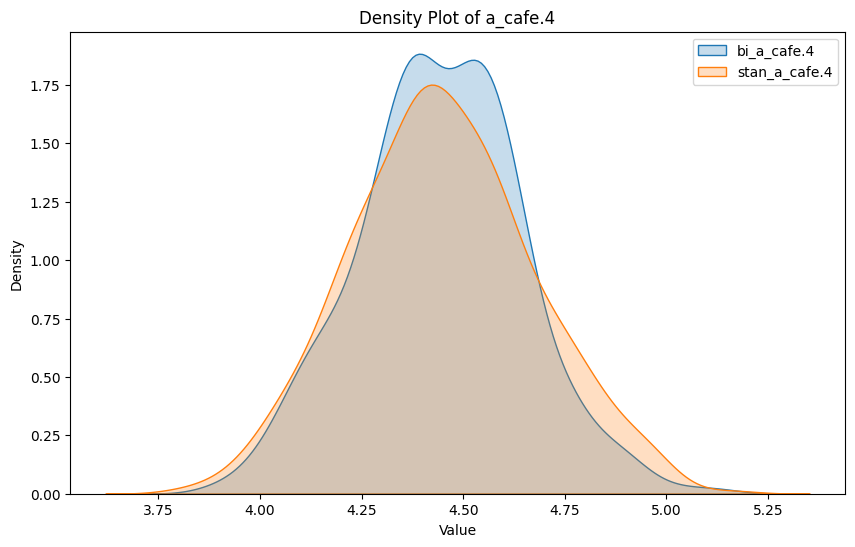

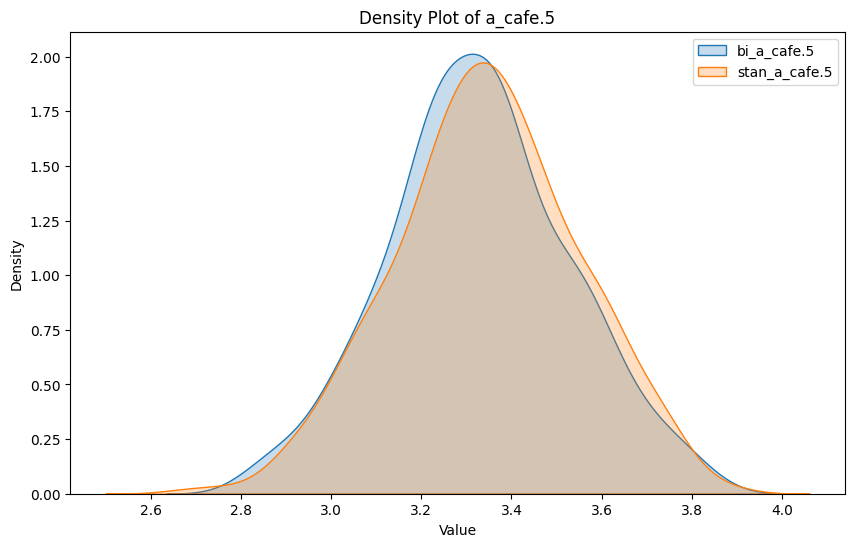

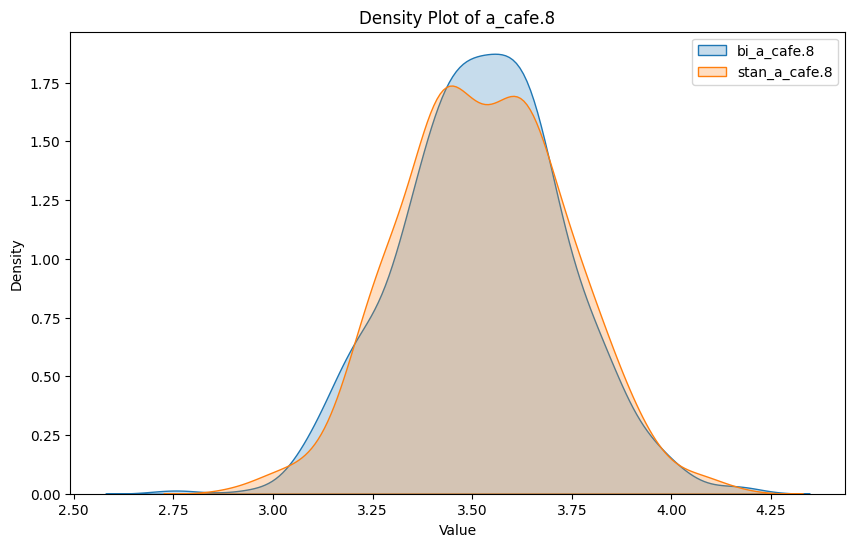

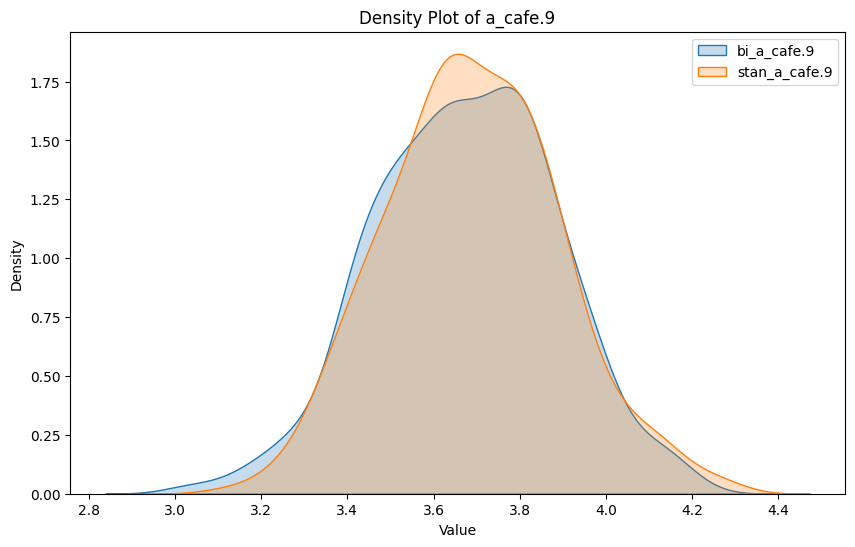

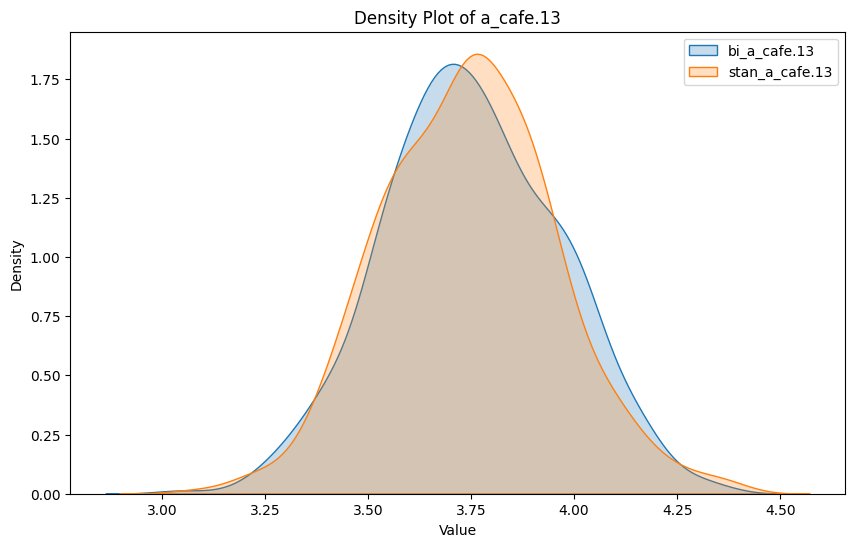

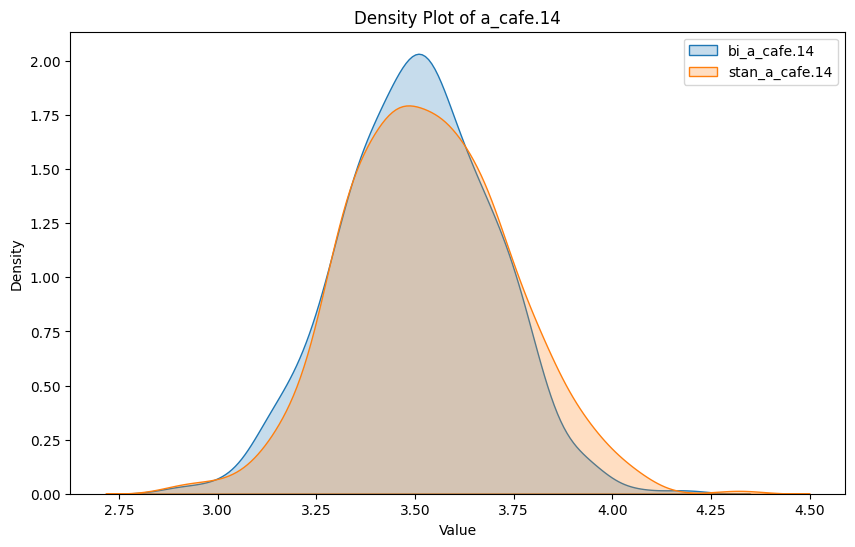

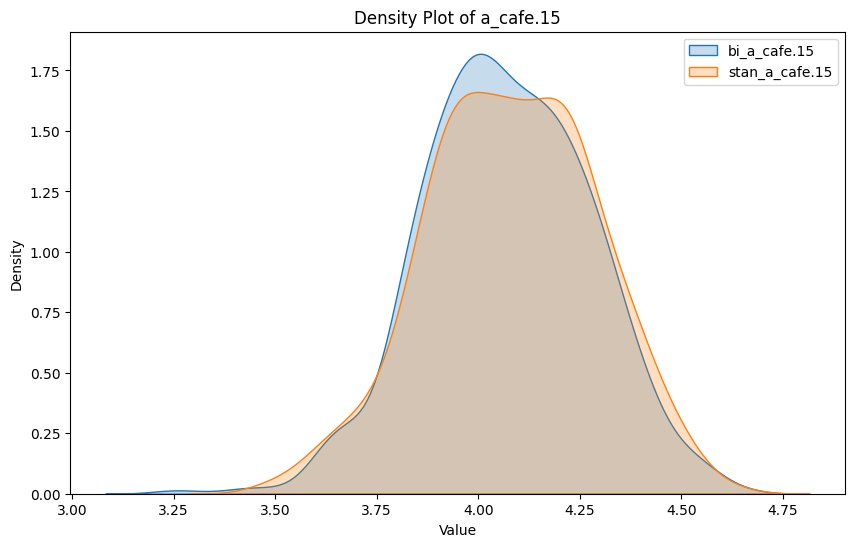

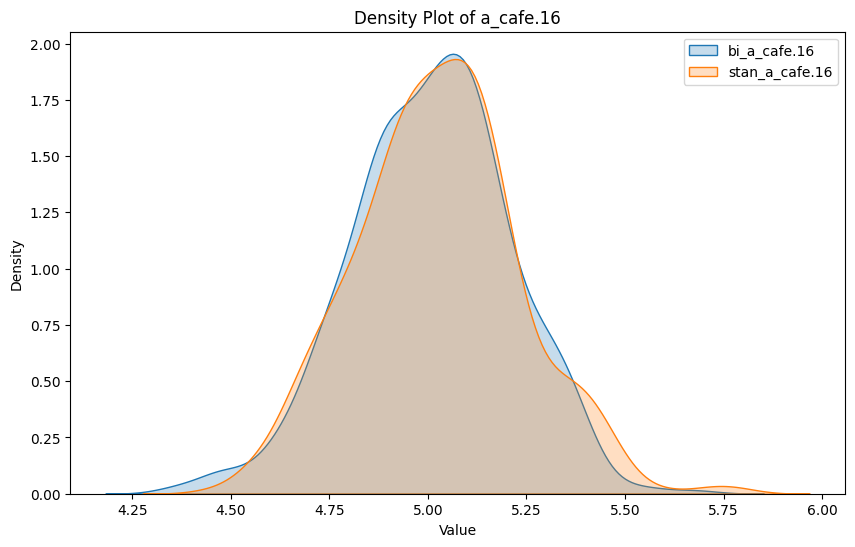

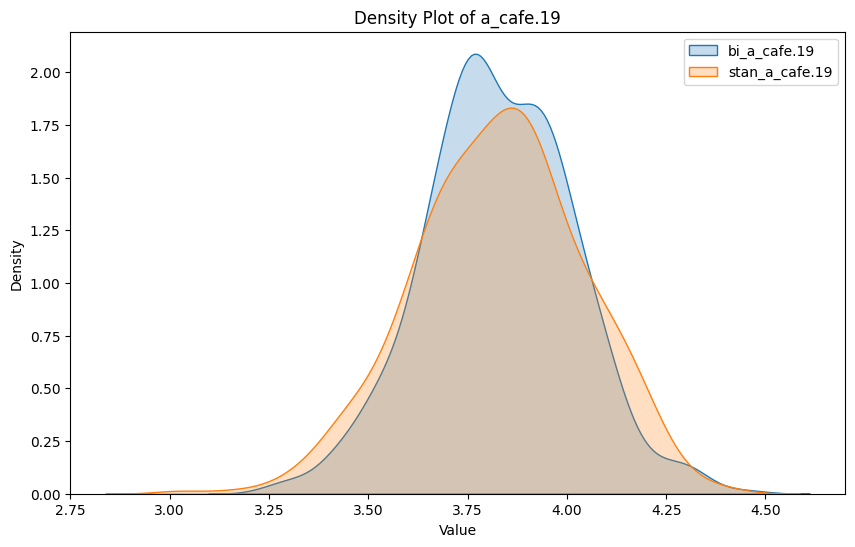

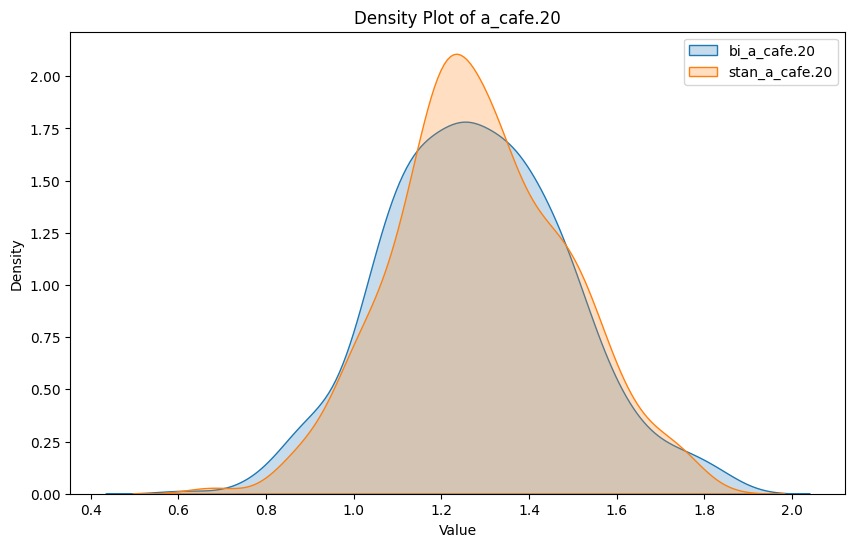

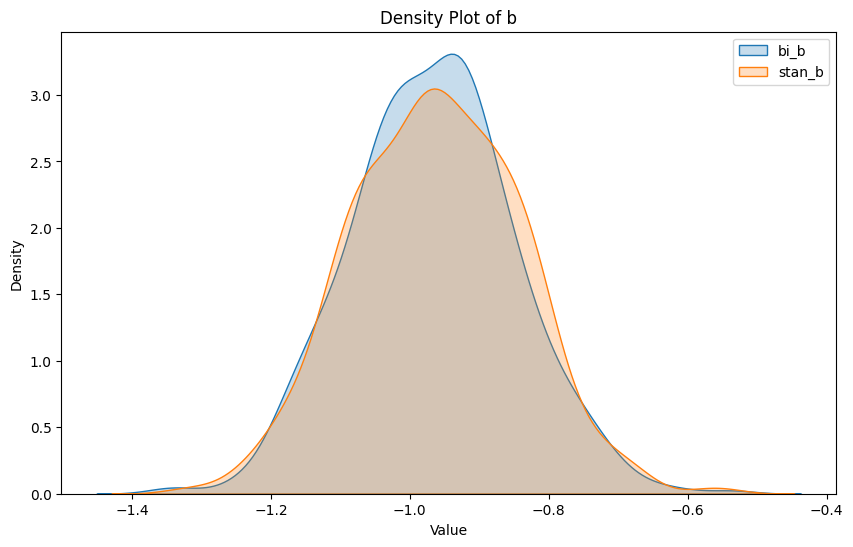

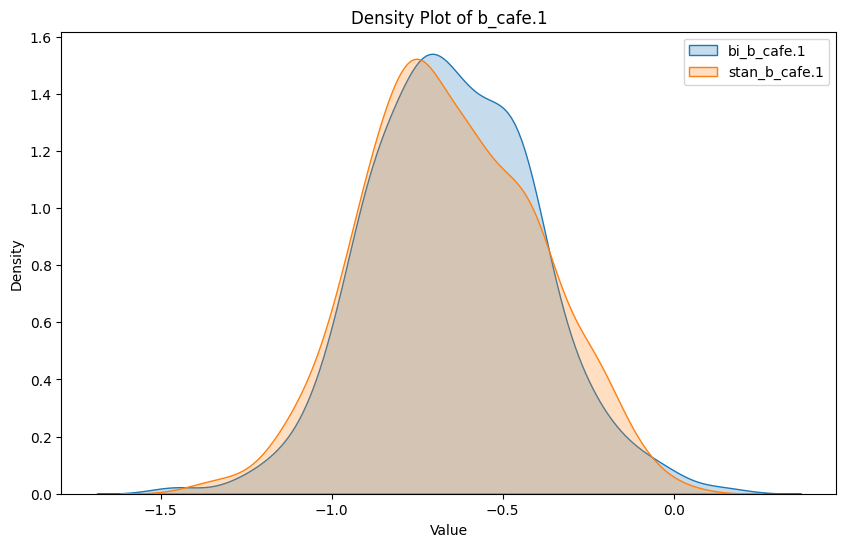

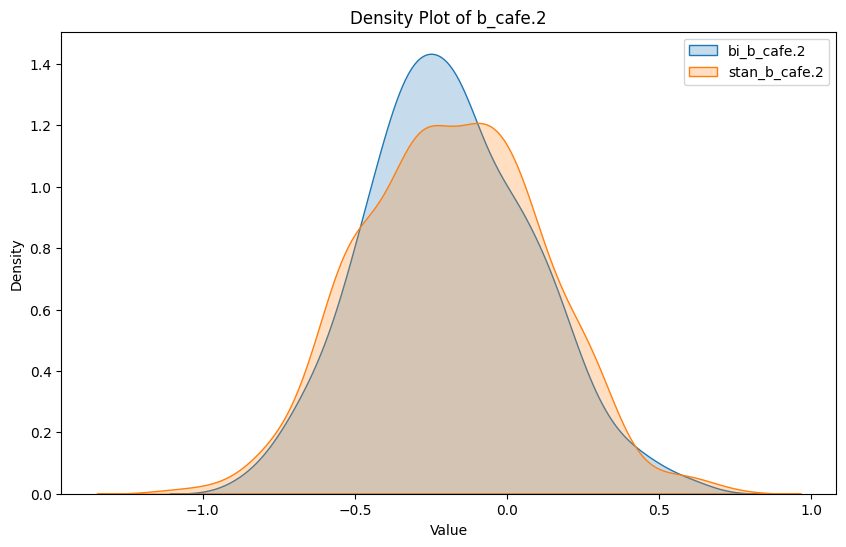

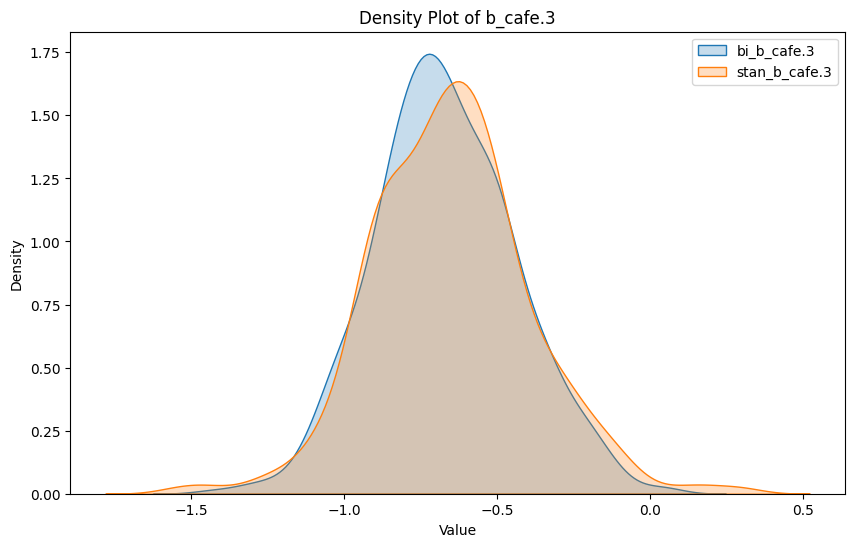

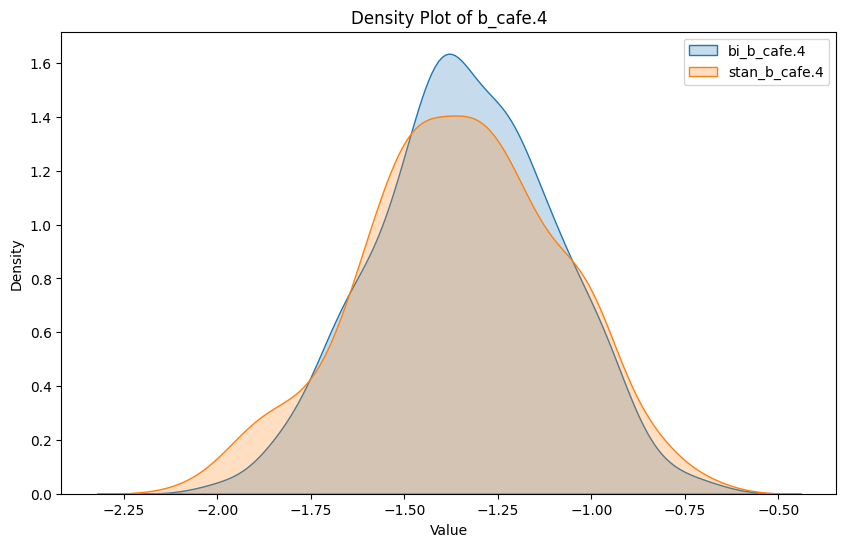

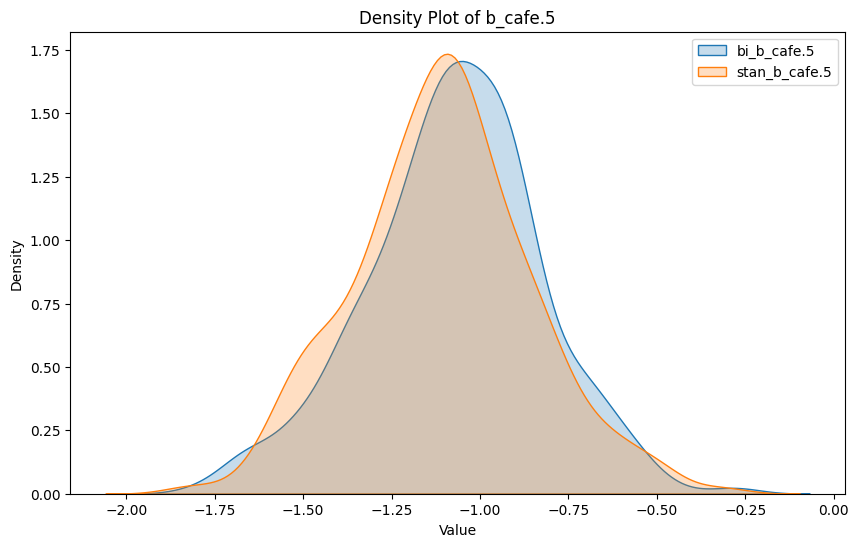

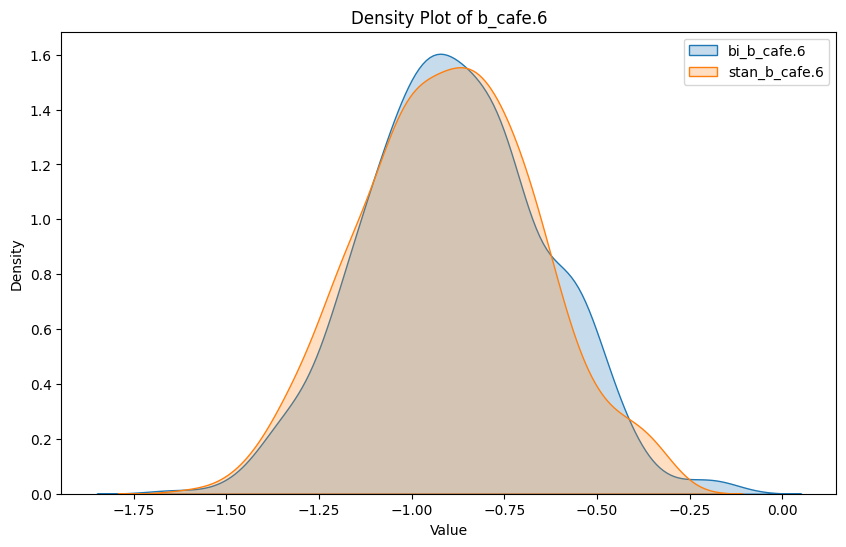

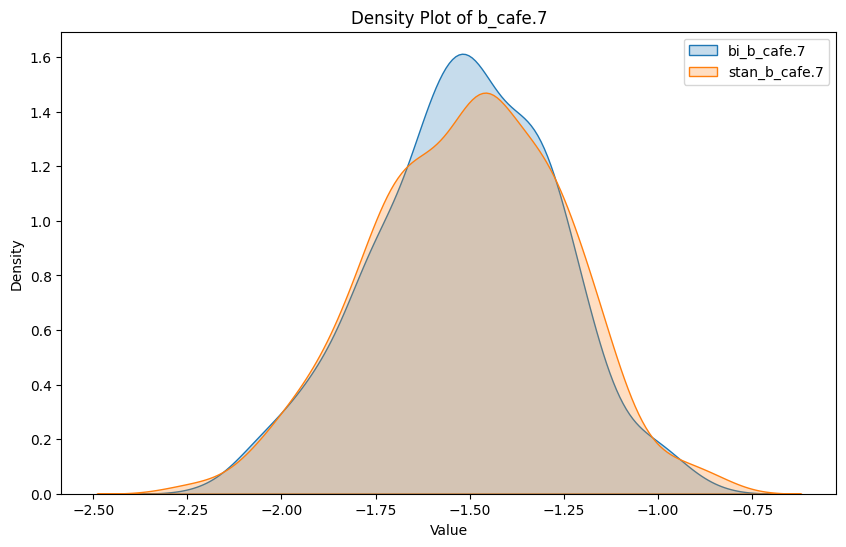

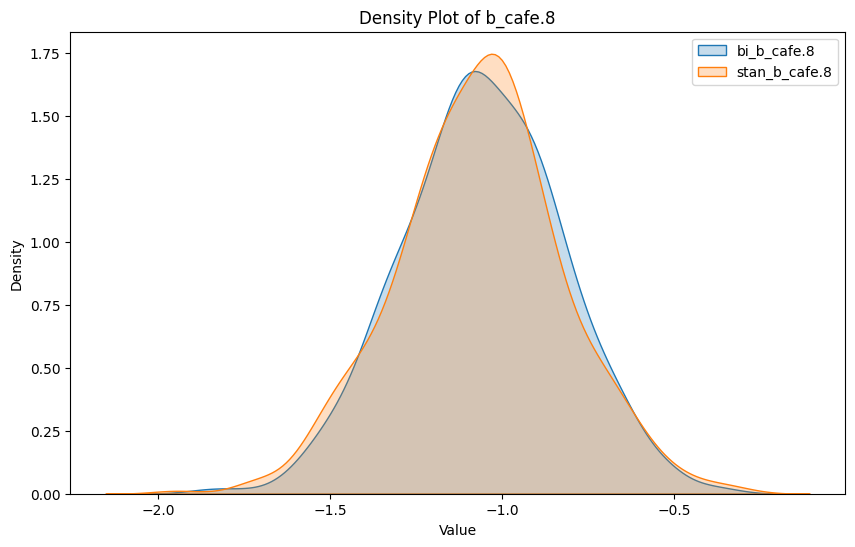

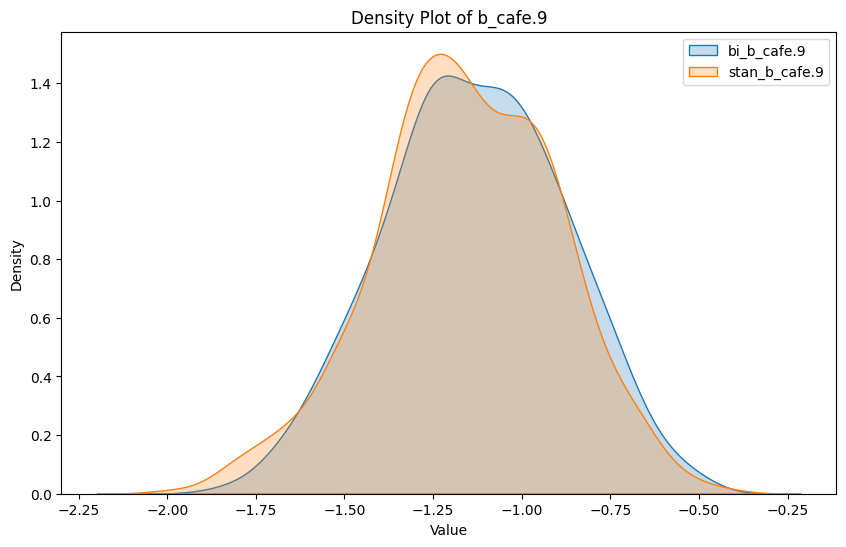

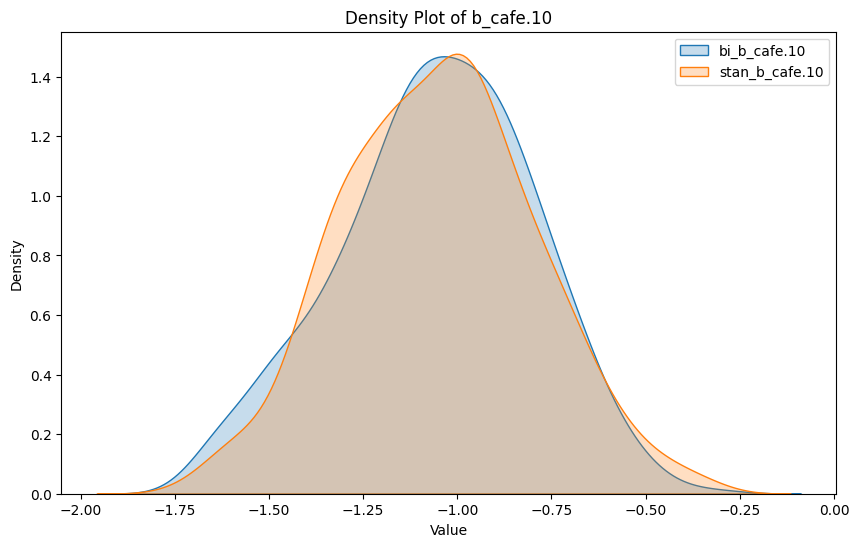

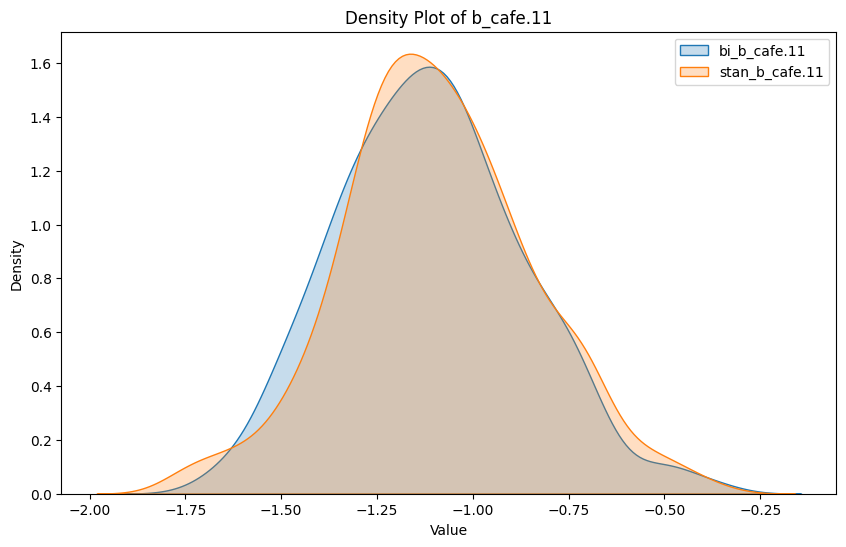

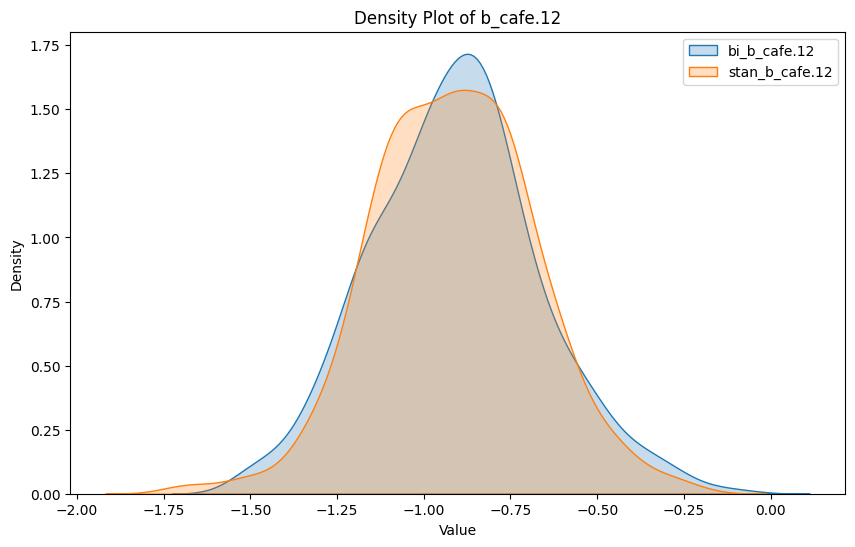

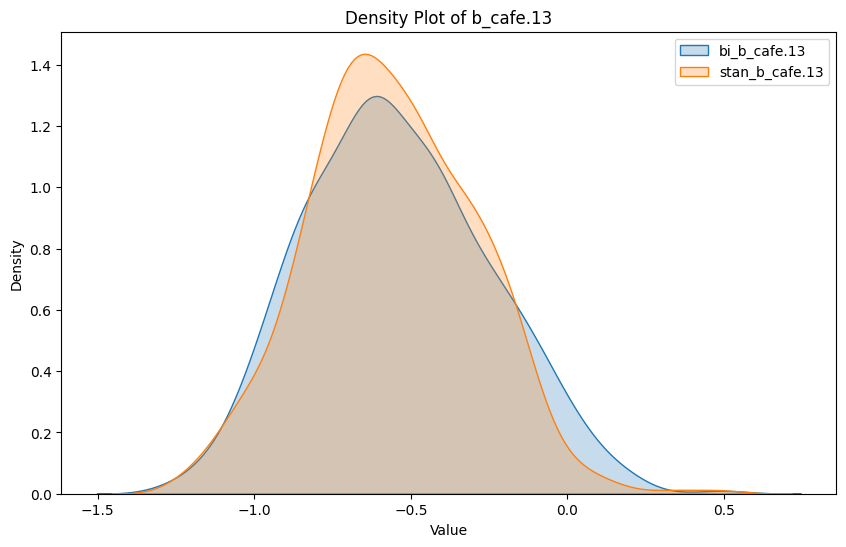

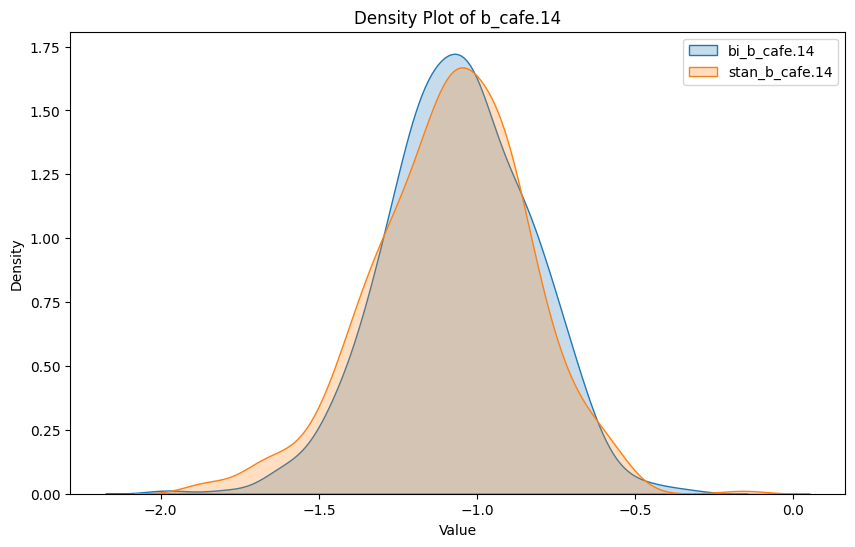

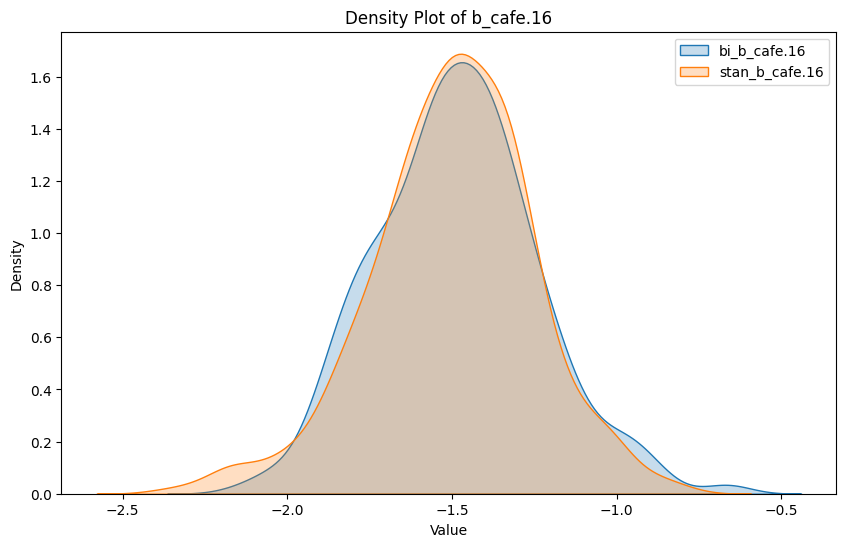

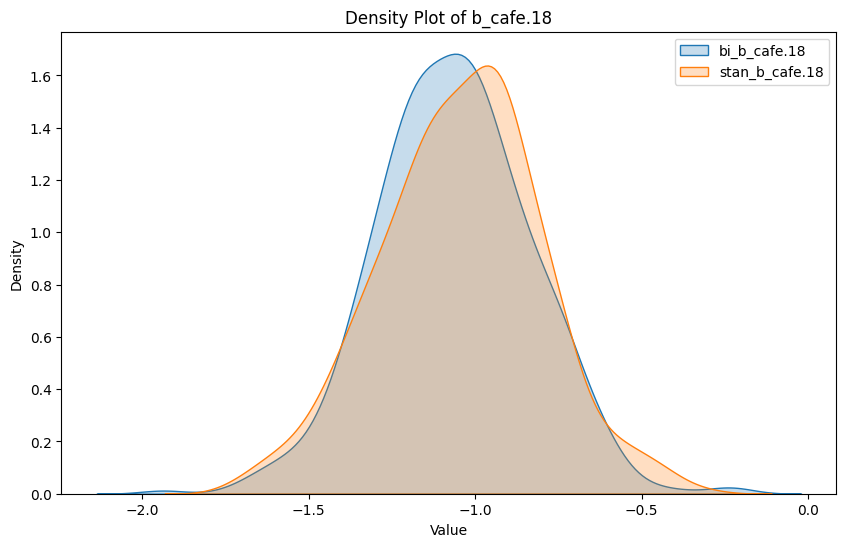

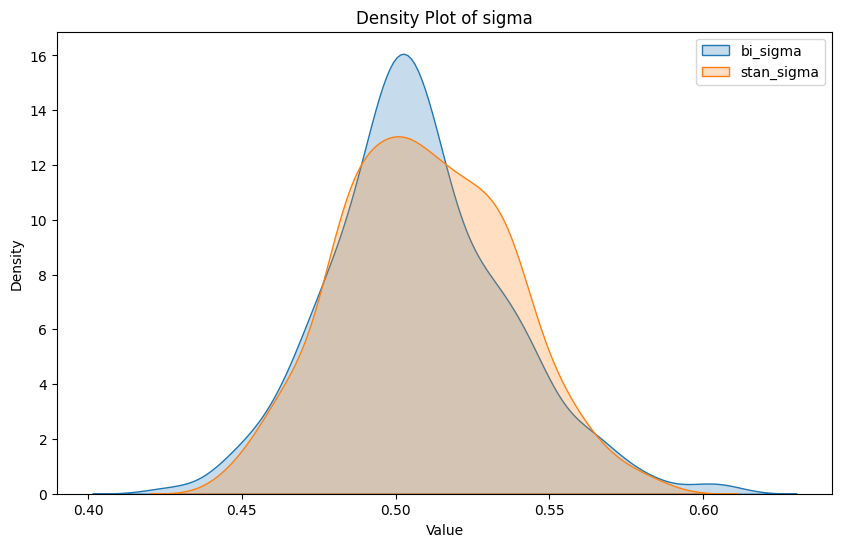

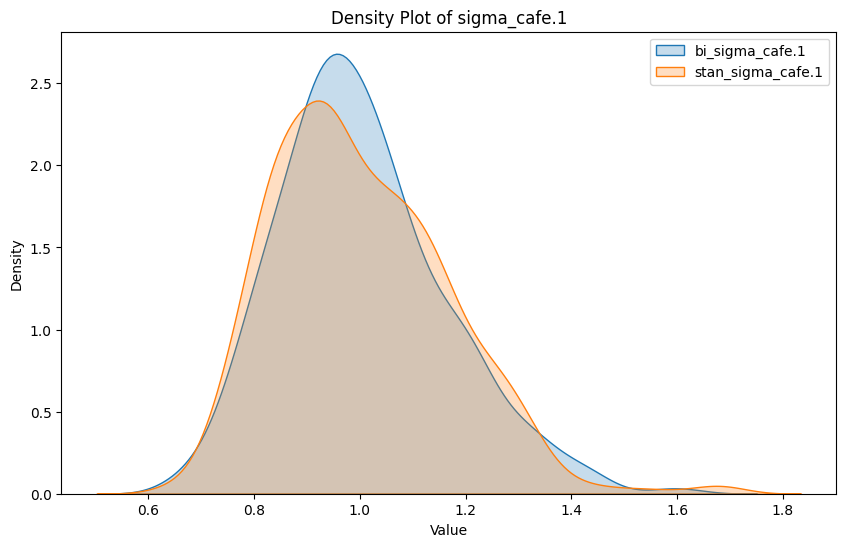

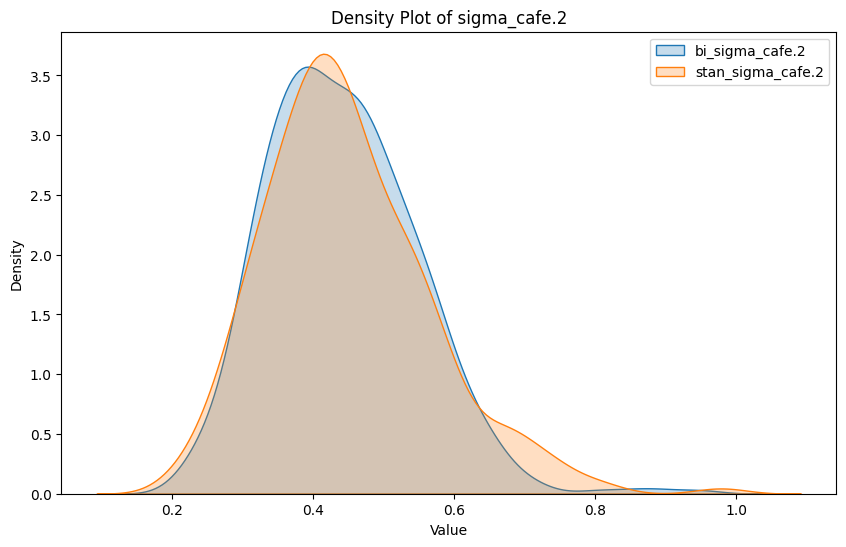

In [166]:
df_bi = prepare_bi_data(m)
df_bi.columns =d.columns
for col in df_bi.columns:
    if col in d.columns:  # Ensure the column exists in both DataFrames
        plt.figure(figsize=(10, 6))  # Create a new figure for each plot
        sns.kdeplot(df_bi[col], label=f'bi_{col}', fill=True)
        sns.kdeplot(d[col], label=f'stan_{col}', fill=True)

        # Add labels and title
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.title(f'Density Plot of {col}')
        plt.legend()

        # Show the plot
        plt.show()

## <a id='toc2_15_'></a>[15. Gaussian Processes](#toc0_)

In [167]:
from main import *
m = bi(platform='cpu')
m.data('../resources/data/Kline2.csv', sep=";")
islandsDistMatrix = pd.read_csv('../resources/data/islandsDistMatrix.csv', index_col=0)
m.data_to_model(['total_tools', 'population'])
m.data_on_model["society"] = jnp.arange(0,10)# index observations
m.data_on_model["Dmat"] = islandsDistMatrix.values # Distance matrix


def model(Dmat, population, society, total_tools):
    a = bi.dist.exponential(1, name = 'a')
    b = bi.dist.exponential(1, name = 'b')
    g = bi.dist.exponential(1, name = 'g')

    # non-centered Gaussian Process prior
    etasq = bi.dist.exponential(2, name = 'etasq')
    rhosq = bi.dist.exponential(0.5, name = 'rhosq')
    z = bi.dist.normal(0,1, name = 'z', shape = (10,))
    SIGMA, L_SIGMA, k = bi.kernel_sq_exp(Dmat, z, etasq, rhosq, 0.01)
 
    lambda_ = a * population**b / g * jnp.exp(k[society])

    lk("T", Poisson(lambda_), obs=total_tools)

# Run sampler ------------------------------------------------
m.run(model, num_samples=500) 
m.summary()

jax.local_device_count 1


sample: 100%|██████████| 1000/1000 [00:01<00:00, 686.59it/s, 127 steps of size 3.54e-02. acc. prob=0.94]


mean    sd  hdi_5.5%  hdi_94.5%
a      1.45  1.12      0.06       2.79
b      0.28  0.08      0.16       0.40
etasq  0.21  0.20      0.02       0.45
g      0.61  0.59      0.03       1.25
rhosq  1.33  1.59      0.02       3.26
z[0]  -0.43  0.77     -1.68       0.69
z[1]   0.45  0.72     -0.68       1.51
z[2]  -0.23  0.80     -1.40       1.13
z[3]   0.99  0.61     -0.00       1.87
z[4]   0.43  0.62     -0.61       1.37
z[5]  -1.01  0.62     -2.04      -0.11
z[6]   0.38  0.57     -0.58       1.20
z[7]  -0.38  0.72     -1.58       0.64
z[8]   0.77  0.66     -0.22       1.82
z[9]  -0.42  0.78     -1.56       0.86